# Configuration

In [1]:
import os
from tqdm.notebook import tqdm
from tqdm import tqdm
import librosa
import pandas as pd 
import pandas as np
from sklearn.metrics import classification_report

# Clean Data - Compute dataframes for datasets and split in Train, Val, Test 

In [2]:
main_path = '/Users/helemanc/Documents/MasterAI/THESIS/Datasets SER'
TESS = os.path.join(main_path, "tess/TESS Toronto emotional speech set data/") 
RAV = os.path.join(main_path, "ravdess-emotional-speech-audio/audio_speech_actors_01-24")
SAVEE = os.path.join(main_path, "savee/ALL/")
CREMA = os.path.join(main_path, "creamd/AudioWAV/")

## RAVDESS

In [3]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[18:20])
            # arr = mfccs, lab
            # lst.append(arr)
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

25it [00:00, 291.20it/s]


In [4]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# merge neutral and calm
emotions_list = ['neutral', 'neutral', 'happy', 'sadness', 'angry', 'fear', 'disgust', 'surprise']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, actors,phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'gender', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors']
df['gender'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

In [5]:
# remove files with noise to apply the same noise to all files for data augmentation 
df = df[~df.path.str.contains('noise')]

In [6]:
df.head()

,emotion,voc_channel,modality,intensity,actors,gender,phrase,path
0,angry,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,speech,audio only,normal,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [7]:
# only speech
RAV_df = df
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

In [8]:
RAV_df.insert(0, "emotion_label", RAV_df.emotion, True)

In [9]:
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)

In [10]:
RAV_df

,emotion_label,actors,gender,path
0,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...,...
2869,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2871,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2872,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2873,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [11]:
RAV_train = []
RAV_val = []
RAV_test = []

In [12]:
for index, row in RAV_df.iterrows():
    if row['actors'] in range(1,21): 
        RAV_train.append(row) 
    elif row['actors'] in range(21,23): 
        RAV_val.append(row)
    elif row['actors'] in range(23,25): 
        RAV_test.append(row)
len(RAV_train), len(RAV_val), len(RAV_test)

(1200, 120, 120)

In [13]:
RAV_train = pd.DataFrame(RAV_train)
RAV_val = pd.DataFrame(RAV_val)
RAV_test = pd.DataFrame(RAV_test)

In [14]:
RAV_train = RAV_train.drop(['actors'], 1)
RAV_val = RAV_val.drop(['actors'], 1)
RAV_test = RAV_test.drop(['actors'], 1)

In [15]:
RAV_train.reset_index(drop=True, inplace = True) 
RAV_val.reset_index(drop=True, inplace = True) 
RAV_test.reset_index(drop=True, inplace = True ) 

## SAVEE

In [16]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
actors = []
gender = []
for i in dir_list:
    actors.append(i[:2])
    if i[-8:-6]=='_a':
        emotion.append('angry')
        gender.append('male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
        gender.append('male')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
        gender.append('male')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
        gender.append('male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
        gender.append('male')
    elif i[-8:-6]=='sa':
        emotion.append('sadness')
        gender.append('male')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
        gender.append('male') 
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
                      
SAVEE_df = pd.concat([SAVEE_df,
                      pd.DataFrame(actors, columns = ['actors']),
                      pd.DataFrame(gender, columns = ['gender']), 
                      pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral     120
sadness      60
happy        60
angry        60
surprise     60
disgust      60
fear         60
Name: emotion_label, dtype: int64

In [17]:
SAVEE_df.head()

,emotion_label,actors,gender,path
0,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,surprise,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [18]:
SAVEE_train = []
SAVEE_val = []
SAVEE_test = []

In [19]:
#DC, JE, JK, KL
for index, row in SAVEE_df.iterrows(): 
    if row['actors'] == 'DC' or row ['actors'] == 'JE':
        SAVEE_train.append(row)
    elif row['actors'] == 'JK': 
        SAVEE_val.append(row)
    else: 
        SAVEE_test.append(row)
len(SAVEE_train), len(SAVEE_val), len(SAVEE_test)

(240, 120, 120)

In [20]:
SAVEE_train = pd.DataFrame(SAVEE_train)
SAVEE_val = pd.DataFrame(SAVEE_val)
SAVEE_test = pd.DataFrame(SAVEE_test)

In [21]:
SAVEE_train = SAVEE_train.drop(['actors'], 1)
SAVEE_val = SAVEE_val.drop(['actors'], 1)
SAVEE_test = SAVEE_test.drop(['actors'], 1)

In [22]:
SAVEE_train = SAVEE_train.reset_index(drop=True) 
SAVEE_val = SAVEE_val.reset_index(drop=True) 
SAVEE_test = SAVEE_test.reset_index(drop=True) 

## TESS

In [23]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

path = []
emotion = []
gender = []
actors = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry':
            emotion.append('angry')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_angry': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_disgust' :
            emotion.append('disgust')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_disgust': 
            emotion.append('disgust')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_Fear':
            emotion.append('fear')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_fear': 
            emotion.append('fear')
            gender.append('female')
            actors.append('YAF') 
            
            
        elif i == 'OAF_happy' :
            emotion.append('happy')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_happy': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_neutral':
            emotion.append('neutral')
            gender.append('female')
            actors.append('OAF')   
        elif i == 'YAF_neutral': 
            emotion.append('neutral')
            gender.append('female')
            actors.append('YAF')      
            
                
        elif i == 'OAF_Pleasant_surprise':
            emotion.append('surprise')
            gender.append('female')
            actors.append('OAF')
        
        elif i == 'YAF_pleasant_surprised': 
            emotion.append('surprise')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_Sad':
            emotion.append('sadness')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_sad': 
            emotion.append('sadness')
            gender.append('female')
            actors.append('YAF')            
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df = pd.concat([TESS_df, pd.DataFrame(gender, columns = ['gender']), 
                     pd.DataFrame(actors, columns= ['actors']),
                     pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

angry       1200
fear         800
surprise     800
neutral      800
sadness      800
disgust      800
happy        400
Name: emotion_label, dtype: int64

In [24]:
TESS_df= TESS_df[~TESS_df.path.str.contains('noise')]

In [25]:
TESS_train = []
TESS_test = []

In [26]:
for index, row in TESS_df.iterrows(): 
    if row['actors'] == 'YAF': 
        TESS_train.append(row)
    else: 
        TESS_test.append(row)
len(TESS_train), len(TESS_test)

(1400, 1400)

In [27]:
TESS_train = pd.DataFrame(TESS_train)
TESS_test = pd.DataFrame(TESS_test)

In [28]:
TESS_train = TESS_train.drop(['actors'], 1)
TESS_test = TESS_test.drop(['actors'], 1)

In [29]:
TESS_train = TESS_train.reset_index(drop=True) 
TESS_test  = TESS_test.reset_index(drop=True) 

## CREMA-D

In [30]:
males = [1,
5,
11,
14,
15,
16,
17,
19,
22,
23,
26,
27,
31,
32,
33,
34,
35,
36,
38,
39,
41,
42,
44,
45,
48,
50,
51,
57,
59, 
62, 
64,
65, 
66,
67,
68,
69,
70,
71,
77, 
80, 
81, 
83, 
85, 
86, 
87,
88, 
90]

In [31]:
females = [ 2,
3,
4,
6,
7,
8,
9,
10,
12,
13,
18,
20,
21,
24,
25,
28,
29,
30,
37,
40,
43,
46,
47,
49,
52,
53,
54,
55,
56, 
58, 
60,
61,
63,
72, 
73, 
74, 
75, 
76, 
78, 
79, 
82, 
84, 
89, 
91]

In [32]:
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []
actors = []
gender = []




for file in crema_directory_list:

    # storing file emotions
    part=file.split('_')
    
    # use only high intensity files
    if "HI" in part[3] :
        actor = part[0][2:]
        actors.append(actor)
        if int(actor) in males:
            gender.append('male')
        else: 
            gender.append('female')
    
        # storing file paths
        file_path.append(CREMA + file)
        if part[2] == 'SAD':
            file_emotion.append('sadness')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotion_label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
actors_df = pd.DataFrame(actors, columns=['actors'])
gender_df = pd.DataFrame(gender, columns=['gender'])                      
Crema_df = pd.concat([emotion_df, actors_df, gender_df, path_df], axis=1)
Crema_df.head()

,emotion_label,actors,gender,path
0,sadness,28,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,angry,48,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,disgust,27,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,disgust,32,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,happy,80,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [33]:
Crema_df.shape

(455, 4)

In [34]:
actor_files = {}

for index, row in Crema_df.iterrows():
    actor = row['actors']
    if actor not in actor_files.keys(): 
        actor_files[actor] = 1
    else: 
        actor_files[actor]+=1

In [35]:
actor_files

{'28': 5,
 '48': 5,
 '27': 5,
 '32': 5,
 '80': 5,
 '59': 5,
 '39': 5,
 '43': 5,
 '56': 5,
 '31': 5,
 '24': 5,
 '51': 5,
 '44': 5,
 '77': 5,
 '62': 5,
 '88': 5,
 '55': 5,
 '40': 5,
 '13': 5,
 '06': 5,
 '35': 5,
 '20': 5,
 '87': 5,
 '09': 5,
 '78': 5,
 '65': 5,
 '70': 5,
 '23': 5,
 '36': 5,
 '01': 5,
 '14': 5,
 '47': 5,
 '52': 5,
 '58': 5,
 '37': 5,
 '22': 5,
 '71': 5,
 '64': 5,
 '50': 5,
 '45': 5,
 '57': 5,
 '42': 5,
 '29': 5,
 '53': 5,
 '46': 5,
 '33': 5,
 '26': 5,
 '34': 5,
 '21': 5,
 '15': 5,
 '08': 5,
 '86': 5,
 '79': 5,
 '63': 5,
 '76': 5,
 '25': 5,
 '30': 5,
 '07': 5,
 '12': 5,
 '41': 5,
 '54': 5,
 '89': 5,
 '81': 5,
 '49': 5,
 '38': 5,
 '05': 5,
 '10': 5,
 '61': 5,
 '74': 5,
 '69': 5,
 '18': 5,
 '83': 5,
 '17': 5,
 '02': 5,
 '73': 5,
 '66': 5,
 '84': 5,
 '91': 5,
 '90': 5,
 '85': 5,
 '03': 5,
 '16': 5,
 '67': 5,
 '72': 5,
 '68': 5,
 '82': 5,
 '19': 5,
 '11': 5,
 '04': 5,
 '75': 5,
 '60': 5}

In [36]:
count_males = 0 
count_females = 0 
male_list = []
for index, row in Crema_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1

In [37]:
count_males, count_females

(235, 220)

Since there are more males than females we will remove randomly 3 male actors (since there are exactly 5 audio files per actor)

In [38]:
import random 
'''
random.seed(42)
males_to_remove = random.sample(male_list, 3)
males_to_remove
'''
males_to_remove = ['17', '80', '88']

In [39]:
new_df = []
for index, row in Crema_df.iterrows(): 
    if row['actors'] not in males_to_remove: 
        new_df.append(row)

In [40]:
CREMA_df = pd.DataFrame(new_df)

In [41]:
for index, row in CREMA_df.iterrows(): 
    if row['actors'] == '17': 
        print("Elements not removed")

In [42]:
count_males = 0 
count_females = 0 
male_list = []
female_list = []
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1
        if actor not in female_list: 
            female_list.append(actor)

In [43]:
count_males, count_females

(220, 220)

In [44]:
len(female_list)

44

In [45]:
len(male_list)

44

In [46]:
CREMA_train = []
CREMA_val = []
CREMA_test = []

In [47]:
females_train = random.sample(female_list, 32)
males_train = random.sample(male_list, 32)

# remove the elements assigned to train 
for element in females_train:
    if element in female_list:
        female_list.remove(element)
        
for element in males_train:
    if element in male_list:
        male_list.remove(element)

         
females_val = random.sample(female_list, 6) 
males_val = random.sample(male_list, 6) 

# remove the elements assigned to val
for element in females_val:
    if element in female_list:
        female_list.remove(element)
        
for element in males_val:
    if element in male_list:
        male_list.remove(element)
        
females_test = random.sample(female_list, 6) 
males_test = random.sample(male_list, 6)        

In [48]:
females_train, males_train, females_val, males_val, females_test, males_test

(['07',
  '06',
  '76',
  '30',
  '04',
  '12',
  '40',
  '13',
  '84',
  '63',
  '21',
  '28',
  '61',
  '24',
  '78',
  '54',
  '03',
  '89',
  '37',
  '02',
  '72',
  '79',
  '91',
  '58',
  '09',
  '75',
  '49',
  '47',
  '60',
  '20',
  '52',
  '25'],
 ['57',
  '83',
  '26',
  '48',
  '59',
  '14',
  '71',
  '67',
  '39',
  '68',
  '81',
  '62',
  '70',
  '23',
  '41',
  '22',
  '85',
  '34',
  '69',
  '11',
  '90',
  '51',
  '27',
  '44',
  '87',
  '19',
  '50',
  '77',
  '45',
  '31',
  '35',
  '38'],
 ['46', '55', '73', '08', '53', '29'],
 ['65', '15', '32', '01', '66', '64'],
 ['82', '56', '18', '10', '43', '74'],
 ['42', '86', '33', '05', '36', '16'])

In [49]:
train = females_train + males_train 
val = females_val + males_val 
test = females_test + males_test

In [50]:
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if actor in train: 
        CREMA_train.append(row)
    elif actor in val: 
        CREMA_val.append(row)
    else:
        CREMA_test.append(row)

In [51]:
CREMA_train = pd.DataFrame(CREMA_train) 
CREMA_val = pd.DataFrame(CREMA_val) 
CREMA_test = pd.DataFrame(CREMA_test)

In [52]:
CREMA_train.shape, CREMA_val.shape, CREMA_test.shape

((320, 4), (60, 4), (60, 4))

In [53]:
CREMA_train = CREMA_train.drop(['actors'], 1)
CREMA_val = CREMA_val.drop(['actors'], 1)
CREMA_test = CREMA_test.drop(['actors'], 1)

In [54]:
CREMA_train = CREMA_train.reset_index(drop=True) 
CREMA_val = CREMA_val.reset_index(drop = True) 
CREMA_test = CREMA_test.reset_index(drop = True)

# Utils Validation Ensemble

In [55]:
# import main
from inaSpeechSegmenter import Segmenter
from argparse import ArgumentParser
import utils
import warnings

In [56]:
# import utils
from speech_emotion_recognition import feature_extraction as fe, ensemble
import scipy
import numpy as np
from scipy import signal
from scipy.io.wavfile import write
from utils import resample, denoise

In [57]:
# other imports 
import sklearn
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [58]:
#!pip install scikit-learn==0.24.2

In [59]:
#!jupyter nbextension enable --py widgetsnbextension

In [60]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [61]:
def make_predictions(dataset, labels, prediction_scheme): 
    predictions = []
    model_predictions_list = []
    counter = 0
    for filepath in tqdm(dataset['path']):
        samples, sample_rate = fe.read_file(filepath)
        samples, sample_rate = resample(samples, sample_rate)
        new_samples = fe.cut_pad(samples)
        #new_filepath = "tmp.wav"
        final_prediction, model_predictions = ensemble.ensemble(new_samples, prediction_scheme, return_model_predictions = True)

        predictions.append(final_prediction)
        model_predictions_list.append(model_predictions) 
        print("True label", labels[counter], "Predicted label", predictions[counter])
        counter+=1
    return predictions, model_predictions_list

def create_dataframe_prediction_per_model(model_predictions_list):
    df_model_predictions = pd.DataFrame(model_predictions_list)
    df_model_predictions = df_model_predictions.reindex(sorted(df_model_predictions.columns), axis=1)
    return df_model_predictions
    
def create_dataframe_predictions(prediction_list):
    df_predictions = pd.DataFrame(prediction_list)
    return df_predictions

def create_dataframe_res(labels, df_predictions, df_model_predictions, dataset): 
    df_res = pd.concat([labels, 
                    df_predictions, 
                    df_model_predictions, 
                    dataset.path], axis = 1, ignore_index=True, sort=False)
    header_model_predictions = list(df_model_predictions.columns)
    new_header = []
    new_header.append('true_label')
    new_header.append('pred_label')
    new_header = new_header + header_model_predictions
    new_header.append('path')
    df_res.columns = new_header
    return df_res
    
def create_dataframes_false_positives_false_negatives(df_res): 
    misclassified_rows_false_positives = []
    misclassified_rows_false_negatives = []
    for index, row in df_res.iterrows():
        true = df_res.true_label[index]
        pred = df_res.pred_label[index]
        if true != pred: # store misclassified files
            if true ==1 and pred == 0: # disruptive classified as non-distruptive is false negative
                misclassified_rows_false_negatives.append(row)
            else:
                misclassified_rows_false_positives.append(row)  
    df_false_negatives = pd.DataFrame(misclassified_rows_false_negatives)
    df_false_negatives.reset_index(drop=True, inplace=True)

    df_false_positives = pd.DataFrame(misclassified_rows_false_positives)
    df_false_positives.reset_index(drop=True, inplace=True)
    
    return df_false_positives, df_false_negatives

def print_hist_models_predictions_fp(df_false_positives): 
    
    if df_false_positives.empty:
        print('DataFrame False Positives is empty!')
        return 0
    df_models_fp = df_false_positives.copy()
    df_models_fp.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fp.hist(figsize=(24,24))
    
def print_hist_models_predictions_fn(df_false_negatives): 
    if df_false_negatives.empty:
        print('DataFrame False Negatives is empty!')
        return 0
    df_models_fn = df_false_negatives.copy()
    df_models_fn.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fn.hist(figsize=(24,24))

# Validation  - RAVDESS

We use the same code of the main.py of the real application, without VAD module

In [62]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}
labels= pd.Series(list(RAV_test.emotion_label)).replace(emotion_enc)

In [63]:
predictions, model_prediction_list = make_predictions(RAV_test, labels, prediction_scheme='avg_2')

  1%|          | 1/120 [00:09<19:34,  9.87s/it]

[0.99864733, 0.9609657, 0.80982685, 0.99956155, 0.9680547, 0.98812973, 0.6062024, 0.99212134, 0.99923515, 0.93658036, 0.99987864, 0.9678956, 0.49413493, 0.9985265, 0.6716299915116171, 0.7025434069821255, 0.5506556164194774, 0.5141547651867352, 0.638547686677007]
True label 1 Predicted label 1


  2%|▏         | 2/120 [00:18<18:48,  9.57s/it]

[0.99059576, 0.6220523, 0.62260556, 0.8400034, 0.638674, 0.8566687, 0.8513299, 0.8371728, 0.9886911, 0.94978154, 0.9980519, 0.85458636, 0.46407506, 0.9769869, 0.6642959982979566, 0.5855623025402305, 0.41676761475192636, 0.43115769194067827, 0.5988600066635208]
True label 1 Predicted label 1


  2%|▎         | 3/120 [00:27<18:03,  9.26s/it]

[0.53715146, 0.47279242, 0.5428347, 0.4445667, 0.548069, 0.5220484, 0.47014916, 0.35243845, 0.41991892, 0.8277079, 0.6627471, 0.29383564, 0.47792146, 0.7882942, 0.6157254305160806, 0.7124836289586796, 0.5366376150087946, 0.5893652031111658, 0.5871613814849761]
True label 1 Predicted label 1


  3%|▎         | 4/120 [00:37<18:36,  9.63s/it]

[0.9321704, 0.8312286, 0.78808177, 0.8246412, 0.887237, 0.84916615, 0.90694, 0.9782812, 0.98352516, 0.86612165, 0.98488325, 0.8308966, 0.47085267, 0.9866523, 0.5797693828725421, 0.7329208059498631, 0.5122240487955877, 0.6406254521060519, 0.5577578052418952]
True label 1 Predicted label 1


  4%|▍         | 5/120 [00:51<20:54, 10.91s/it]

[0.9935558, 0.84432775, 0.6000461, 0.94424415, 0.5980262, 0.9784219, 0.42825705, 0.9984257, 0.98181903, 0.84183884, 0.994733, 0.6487325, 0.4526406, 0.6734678, 0.6896874451102362, 0.9103841810558084, 0.47253761231670843, 0.5647351609268054, 0.65210157702659]
True label 1 Predicted label 1


  5%|▌         | 6/120 [01:00<19:29, 10.26s/it]

[0.95904136, 0.46673268, 0.67485213, 0.9477556, 0.5925212, 0.95203096, 0.79150057, 0.9254403, 0.9870548, 0.96278274, 0.9278852, 0.6374972, 0.49209067, 0.89982146, 0.4332632656452049, 0.6456528573896431, 0.3643868739636705, 0.4232245010432557, 0.3490315165676187]
True label 1 Predicted label 1


  6%|▌         | 7/120 [01:10<19:30, 10.35s/it]

[0.24878111, 0.21907502, 0.4669059, 0.5043085, 0.27471355, 0.41658625, 0.45489413, 0.31555516, 0.41401565, 0.66524327, 0.52808356, 0.090865046, 0.47065854, 0.38217825, 0.5757617763493359, 0.630131642155621, 0.48884344037318106, 0.5266328570573822, 0.5398456125733232]
True label 1 Predicted label 0


  7%|▋         | 8/120 [01:19<18:31,  9.92s/it]

[0.9269745, 0.242491, 0.45362827, 0.7900915, 0.32889628, 0.39375785, 0.32642478, 0.3535679, 0.28878027, 0.8331104, 0.7297157, 0.098056376, 0.48212066, 0.5964075, 0.6653879213165284, 0.6447752667361986, 0.44930634570017774, 0.4946915522227259, 0.5906386844745433]
True label 1 Predicted label 1


  8%|▊         | 9/120 [01:29<18:09,  9.81s/it]

[0.04610747, 0.0549089, 0.2665887, 0.049016, 0.13914344, 0.009115487, 0.2820657, 0.0013157725, 0.0049009025, 0.70607775, 0.0011411309, 0.04950869, 0.44311172, 0.021656841, 0.6075713748020366, 0.5107904187599059, 0.38406454036984283, 0.36499190456827285, 0.5373519445763097]
True label 0 Predicted label 0


  8%|▊         | 10/120 [01:38<17:29,  9.54s/it]

[0.010546058, 0.1237106, 0.25036433, 0.030788451, 0.2359885, 0.006817937, 0.05240962, 0.011006743, 0.0018426478, 0.8364208, 6.2660445e-05, 0.11329162, 0.47568566, 0.07793629, 0.617827055928963, 0.5056081064405283, 0.3444292761879093, 0.34277878397687017, 0.528506707394451]
True label 0 Predicted label 0


  9%|▉         | 11/120 [01:48<17:33,  9.66s/it]

[0.0011739135, 0.004464984, 0.16566947, 0.048639357, 0.03518316, 0.006575376, 0.3460434, 0.00071027875, 0.05375427, 0.9133505, 0.022709817, 0.0015159249, 0.49218374, 0.01750189, 0.638866838936236, 0.6273354048045277, 0.5750863212019744, 0.47458891261287295, 0.6214368353430839]
True label 0 Predicted label 0


 10%|█         | 12/120 [01:57<16:58,  9.43s/it]

[0.10829425, 0.03270799, 0.17829803, 0.2219306, 0.0962469, 0.070546, 0.015938312, 0.015075922, 0.017677635, 0.5561553, 0.08835387, 0.0035654604, 0.5304917, 0.14726883, 0.49425408822860506, 0.647615302520253, 0.3634820486902963, 0.5600271365853515, 0.45137060473522206]
True label 0 Predicted label 0


 11%|█         | 13/120 [02:06<16:44,  9.38s/it]

[0.055914223, 0.03275451, 0.3389274, 0.18581033, 0.13176447, 0.11973235, 0.5429561, 0.018871635, 0.47353318, 0.8636409, 0.25662032, 0.21492893, 0.47021475, 0.33204997, 0.5212539598274938, 0.7022266047437921, 0.44119716072731, 0.5243397682273799, 0.4893516154322796]
True label 0 Predicted label 0


 12%|█▏        | 14/120 [02:17<17:18,  9.80s/it]

[0.3920228, 0.25300497, 0.39708045, 0.24691388, 0.37165636, 0.52999187, 0.22990316, 0.10126838, 0.29797137, 0.70394135, 0.47642565, 0.34058842, 0.53740126, 0.34777123, 0.443748786814747, 0.7499094458648351, 0.32321043420224477, 0.6093529103474316, 0.39282803180046577]
True label 0 Predicted label 0


 12%|█▎        | 15/120 [02:28<18:00, 10.30s/it]

[0.26113284, 0.17552966, 0.24547216, 0.18923345, 0.24083522, 0.13550454, 0.26803094, 0.48957276, 0.018630058, 0.9428339, 0.0040890872, 0.054029226, 0.46473542, 0.21494365, 0.6336045578570865, 0.6057672475433061, 0.39020140296653555, 0.494657866907478, 0.5132146351504135]
True label 0 Predicted label 0


 13%|█▎        | 16/120 [02:39<17:58, 10.37s/it]

[0.019020438, 0.08179021, 0.27577958, 0.16889524, 0.2826209, 0.046114087, 0.23906273, 0.06749672, 0.12437013, 0.8367511, 0.20006609, 0.05750972, 0.5116465, 0.20459309, 0.5249230753751869, 0.6212950239269126, 0.33554742008850236, 0.48908794982994536, 0.46133424766053793]
True label 0 Predicted label 0


 14%|█▍        | 17/120 [02:49<17:57, 10.46s/it]

[0.024894089, 0.016952962, 0.17857483, 0.2659456, 0.086462855, 0.116304845, 0.6989544, 0.010205716, 0.3569184, 0.9438424, 0.24342772, 0.083928704, 0.4477211, 0.051594853, 0.5431163195884429, 0.66237994304913, 0.4540791708757313, 0.4879759525814059, 0.5114122719796294]
True label 0 Predicted label 0


 15%|█▌        | 18/120 [03:10<22:59, 13.53s/it]

[0.03958288, 0.021904886, 0.2478376, 0.36799198, 0.1546931, 0.016205221, 0.9510386, 0.0031691194, 0.19480431, 0.94355303, 0.06374976, 0.028945625, 0.50940937, 0.77074265, 0.6586985894155922, 0.6571403037166866, 0.6755756265644172, 0.44845393538130185, 0.6424508369546097]
True label 0 Predicted label 0


 16%|█▌        | 19/120 [03:21<21:18, 12.66s/it]

[0.36147368, 0.20822826, 0.2740987, 0.37605566, 0.18435603, 0.20127797, 0.06669828, 0.014868617, 0.0040335655, 0.68937457, 0.09836149, 0.021237135, 0.4998949, 0.287086, 0.5647432902533415, 0.6399897800993539, 0.3485432097355918, 0.5974056287948017, 0.4743959500331864]
True label 0 Predicted label 0


 17%|█▋        | 20/120 [03:39<23:55, 14.35s/it]

[0.5424331, 0.17438903, 0.23000675, 0.51913697, 0.20240033, 0.31660283, 0.49841684, 0.28603607, 0.016349047, 0.93679166, 0.20541158, 0.024388522, 0.4702674, 0.1542798, 0.6373379730473833, 0.627263291150327, 0.4205902575530464, 0.5, 0.5311090061080096]
True label 0 Predicted label 0


 18%|█▊        | 21/120 [03:50<22:11, 13.45s/it]

[0.98530185, 0.6259441, 0.6396454, 0.9263875, 0.7009603, 0.7389356, 0.91970176, 0.59817785, 0.88247716, 0.9587646, 0.99821913, 0.68104815, 0.5119691, 0.75374556, 0.6802311529112361, 0.6541658350598315, 0.5893747975951427, 0.47984737958527274, 0.6466168403612602]
True label 1 Predicted label 1


 18%|█▊        | 22/120 [04:10<24:50, 15.21s/it]

[0.96326315, 0.82435596, 0.77020866, 0.9202277, 0.8705373, 0.97679746, 0.88067174, 0.9249084, 0.98498565, 0.82471013, 0.99813837, 0.5413898, 0.4889673, 0.96478397, 0.5843609072953403, 0.7478246727873132, 0.5, 0.53387551138917, 0.5288725359281186]
True label 1 Predicted label 1


 19%|█▉        | 23/120 [04:19<21:53, 13.54s/it]

[0.98540986, 0.6637976, 0.5899515, 0.89039165, 0.8232875, 0.93999183, 0.42095387, 0.93736374, 0.98975307, 0.5419225, 0.9980426, 0.47159544, 0.443589, 0.90038586, 0.6002720704134747, 0.7180795412096602, 0.4887258459321664, 0.6156357093286748, 0.5708142191186184]
True label 1 Predicted label 1


 20%|██        | 24/120 [04:28<19:33, 12.22s/it]

[0.87699735, 0.26414526, 0.37976316, 0.66628456, 0.2856056, 0.84965634, 0.09326875, 0.34124738, 0.86192024, 0.62905294, 0.9299208, 0.12755212, 0.5128802, 0.2871629, 0.5173114839851157, 0.6697989729010732, 0.41242596927494024, 0.5114908875334342, 0.47156669713408944]
True label 1 Predicted label 1


 21%|██        | 25/120 [04:38<17:51, 11.28s/it]

[0.99995315, 0.7432427, 0.79605734, 0.99720865, 0.8716441, 0.9979906, 0.24896249, 0.8838749, 0.9998044, 0.9043615, 0.9992391, 0.62709856, 0.5087868, 0.8924844, 0.5283240217956404, 0.6740543723632909, 0.35653441739026503, 0.4733140796016924, 0.4412675701685952]
True label 1 Predicted label 1


 22%|██▏       | 26/120 [04:47<16:40, 10.64s/it]

[0.97888756, 0.41127038, 0.5066414, 0.8687326, 0.46923062, 0.9909446, 0.11807755, 0.9898256, 0.97431326, 0.8612062, 0.9973868, 0.42459148, 0.49395943, 0.48447773, 0.7052078963758928, 0.838330810920777, 0.4743120921868346, 0.5526816743707059, 0.6322517080903157]
True label 1 Predicted label 1


 22%|██▎       | 27/120 [04:56<15:41, 10.12s/it]

[0.84612614, 0.15035164, 0.2077297, 0.584947, 0.38241652, 0.0923647, 0.7655695, 0.39896667, 0.14649978, 0.9558152, 0.24452603, 0.25527078, 0.50255054, 0.2961954, 0.6935157296431739, 0.6480544731247531, 0.490118963098801, 0.5127282801409316, 0.6130495069195481]
True label 1 Predicted label 0


 23%|██▎       | 28/120 [05:04<14:57,  9.75s/it]

[0.40008953, 0.4366241, 0.4070894, 0.4908048, 0.54064494, 0.57657397, 0.49797344, 0.5314973, 0.32363242, 0.7591389, 0.69064283, 0.40555596, 0.49851567, 0.6131791, 0.5441932764590304, 0.6935219459018531, 0.43214685156375776, 0.6145870453694712, 0.5110934615503724]
True label 1 Predicted label 1


 24%|██▍       | 29/120 [05:13<14:14,  9.39s/it]

[0.124080926, 0.13500527, 0.32876655, 0.10731134, 0.17369735, 0.04516521, 0.057127595, 0.010538697, 0.016609102, 0.6371523, 0.05017653, 0.09253347, 0.4561675, 0.105157286, 0.598852825410197, 0.588846380971168, 0.3728324993780859, 0.5052015227278965, 0.5175919626631128]
True label 0 Predicted label 0


 25%|██▌       | 30/120 [05:22<13:49,  9.21s/it]

[0.07233822, 0.064733684, 0.18002528, 0.093699366, 0.23280728, 0.03259316, 0.27634948, 0.06723645, 0.041030884, 0.8031571, 0.00036215782, 0.019175053, 0.43698472, 0.15988624, 0.605064827387755, 0.5485006271507248, 0.35710636851873967, 0.4218619224399738, 0.5128444514505736]
True label 0 Predicted label 0


 26%|██▌       | 31/120 [05:31<13:34,  9.15s/it]

[0.2942956, 0.19094288, 0.28001451, 0.46704257, 0.27547047, 0.11051625, 0.16711822, 0.6496868, 0.034742624, 0.9184195, 0.009002447, 0.046496302, 0.4689613, 0.3032551, 0.6489955757295556, 0.5957114043294699, 0.4094494436331854, 0.5210265015717622, 0.5372989365234652]
True label 0 Predicted label 0


 27%|██▋       | 32/120 [05:39<13:09,  8.97s/it]

[0.72407347, 0.12485021, 0.4373268, 0.4408154, 0.23842025, 0.5822616, 0.511339, 0.03917876, 0.4961473, 0.8477649, 0.7971961, 0.15146291, 0.4885371, 0.1487127, 0.4708361983609583, 0.7078747847783724, 0.3475365725553984, 0.56453205537492, 0.4157975773090809]
True label 0 Predicted label 0


 28%|██▊       | 33/120 [05:48<12:53,  8.89s/it]

[0.057641268, 0.04516253, 0.3154714, 0.3740281, 0.27904058, 0.05989963, 0.8343011, 0.011497617, 0.6686636, 0.8768846, 0.38610348, 0.28474075, 0.5162724, 0.38779938, 0.6212956903242359, 0.6796347897985213, 0.6114526060009331, 0.4484588095577087, 0.5827312625045383]
True label 0 Predicted label 0


 28%|██▊       | 34/120 [05:57<12:44,  8.89s/it]

[0.27800483, 0.062660426, 0.28984478, 0.2296153, 0.22096306, 0.16455674, 0.07506904, 0.033954024, 0.09095591, 0.89608264, 0.048134893, 0.012849122, 0.5281328, 0.38792485, 0.5514223732905693, 0.7067479593830023, 0.42477589861872445, 0.5729041727475995, 0.49369922880210526]
True label 0 Predicted label 0


 29%|██▉       | 35/120 [06:06<12:26,  8.78s/it]

[0.022987396, 0.0076082945, 0.15457681, 0.32511422, 0.036331713, 0.06227678, 0.75965166, 0.0017352402, 0.23199892, 0.9829211, 0.014996171, 0.001586318, 0.44198358, 0.07512376, 0.6138814573816651, 0.7342409938616425, 0.5892915759691243, 0.5902283851408175, 0.5874945483626013]
True label 0 Predicted label 0


 30%|███       | 36/120 [06:14<12:14,  8.75s/it]

[0.9928831, 0.38417086, 0.43139842, 0.8289598, 0.4459705, 0.6247143, 0.46794504, 0.7343706, 0.6838697, 0.9295073, 0.9655208, 0.34226304, 0.5084243, 0.6396185, 0.6410389470815968, 0.6429911843798349, 0.45643334829957705, 0.4723942621711235, 0.5689050166056902]
True label 1 Predicted label 1


 31%|███       | 37/120 [06:24<12:22,  8.94s/it]

[0.97220737, 0.6304906, 0.5895772, 0.839217, 0.6211346, 0.95984423, 0.13677421, 0.87996054, 0.9027672, 0.5781812, 0.99327314, 0.33258665, 0.47542474, 0.78576213, 0.5321212086542618, 0.6791012451116131, 0.3816309441545974, 0.5317043032282451, 0.4846693597441519]
True label 1 Predicted label 1


 32%|███▏      | 38/120 [06:33<12:21,  9.04s/it]

[0.026912928, 0.29460686, 0.39215523, 0.06414741, 0.29705906, 0.17155328, 0.776258, 0.22686008, 0.10470334, 0.96394026, 0.14097652, 0.13371277, 0.4691738, 0.2791563, 0.5620503196953707, 0.7031925163832058, 0.3791171478762554, 0.455625038196972, 0.47902924313312156]
True label 1 Predicted label 0


 32%|███▎      | 39/120 [06:42<12:10,  9.02s/it]

[0.9896667, 0.85005677, 0.45966062, 0.9359925, 0.59480965, 0.9843744, 0.8555769, 0.9990766, 0.99536324, 0.9790656, 0.9983889, 0.7220256, 0.46674556, 0.83085406, 0.7454293912595207, 0.8421682043361154, 0.5192251347546051, 0.5133741853894687, 0.6875286091912176]
True label 1 Predicted label 1


 33%|███▎      | 40/120 [06:50<11:52,  8.91s/it]

[0.9531528, 0.6978326, 0.6223313, 0.6571731, 0.59779584, 0.915336, 0.83426154, 0.9901775, 0.94503736, 0.83478355, 0.97246075, 0.70373476, 0.4779538, 0.9687213, 0.6698192485661093, 0.7377589878367697, 0.613561151112763, 0.6367257794976541, 0.6558451839473265]
True label 1 Predicted label 1


 34%|███▍      | 41/120 [06:59<11:34,  8.79s/it]

[0.53903776, 0.47837806, 0.48896223, 0.5230274, 0.542624, 0.5903962, 0.6664693, 0.39289054, 0.70954704, 0.9402571, 0.82894146, 0.25569308, 0.5147286, 0.7652328, 0.5980817867883256, 0.7016122835533352, 0.48786702927716086, 0.5838468584453708, 0.5662974212569989]
True label 1 Predicted label 1


 35%|███▌      | 42/120 [07:09<11:50,  9.11s/it]

[0.9853754, 0.4731994, 0.6038425, 0.8274, 0.6223091, 0.7783303, 0.8147627, 0.5636753, 0.929271, 0.9894436, 0.9582728, 0.7501091, 0.5172072, 0.6969752, 0.562906037278629, 0.7480979781700718, 0.35445633342170646, 0.6067169182810391, 0.4859198889937488]
True label 1 Predicted label 1


 36%|███▌      | 43/120 [07:17<11:29,  8.96s/it]

[0.99999857, 0.9341959, 0.8823681, 0.99998665, 0.97645414, 0.9999721, 0.7664456, 0.9988537, 0.99996746, 0.96242, 0.99999964, 0.9898326, 0.528178, 0.99959606, 0.6250788757741543, 0.766845211385182, 0.5159371621217116, 0.6066397208084154, 0.5586611347989507]
True label 1 Predicted label 1


 37%|███▋      | 44/120 [07:26<11:09,  8.81s/it]

[0.030015051, 0.18141198, 0.28422466, 0.04063177, 0.20599079, 0.034433693, 0.036831915, 0.070265174, 0.0012655556, 0.83956677, 5.5413264e-05, 0.025700122, 0.4965059, 0.17654201, 0.7134088471815041, 0.5153360850888654, 0.4143137675816346, 0.3545796889355783, 0.6188073349878647]
True label 0 Predicted label 0


 38%|███▊      | 45/120 [07:35<11:07,  8.90s/it]

[0.06373051, 0.069054484, 0.20842174, 0.06788948, 0.18892765, 0.024962753, 0.20594391, 0.0123975575, 0.007904053, 0.6314651, 0.00313887, 0.07211313, 0.4453005, 0.0739007, 0.5979286268261287, 0.5176121495424705, 0.3481106389236901, 0.3632447329308943, 0.5195430779646083]
True label 0 Predicted label 0


 38%|███▊      | 46/120 [07:44<11:03,  8.97s/it]

[0.30053234, 0.4096595, 0.4728405, 0.4581226, 0.5640105, 0.32175702, 0.620056, 0.40039742, 0.24894765, 0.75241137, 0.50863653, 0.465994, 0.50054175, 0.68184227, 0.5794115657220523, 0.6784796615469488, 0.43928294956387887, 0.5781763099142417, 0.5418947710356706]
True label 1 Predicted label 1


 39%|███▉      | 47/120 [07:52<10:39,  8.76s/it]

[0.9578303, 0.113963336, 0.31814885, 0.46920624, 0.33041078, 0.29554802, 0.62128174, 0.31430936, 0.12641364, 0.8571862, 0.17582399, 0.15277112, 0.51284015, 0.50797826, 0.6515377207585239, 0.6387354735810695, 0.48340221035290687, 0.5, 0.5909784760703846]
True label 1 Predicted label 0


 40%|████      | 48/120 [08:01<10:28,  8.73s/it]

[0.9577372, 0.5911407, 0.56729436, 0.73132485, 0.69935286, 0.97012055, 0.8231165, 0.9946947, 0.8906238, 0.976905, 0.94704366, 0.8347503, 0.4948586, 0.72510946, 0.657856197067556, 0.8669823305959772, 0.470593662667014, 0.6224486446239925, 0.5698890778883516]
True label 1 Predicted label 1


 41%|████      | 49/120 [08:10<10:23,  8.78s/it]

[0.9988277, 0.44975182, 0.64981616, 0.96564585, 0.53392047, 0.9870845, 0.33693057, 0.834708, 0.9997419, 0.92277426, 0.9981941, 0.5097423, 0.50101626, 0.8963238, 0.5849109638915815, 0.7648047211287278, 0.41097068423777267, 0.5535384476435131, 0.5101006657598488]
True label 1 Predicted label 1


 42%|████▏     | 50/120 [08:18<10:08,  8.69s/it]

[0.6736102, 0.43292478, 0.48561397, 0.56968164, 0.41733396, 0.6476962, 0.19755685, 0.24377114, 0.8847568, 0.8663336, 0.8601272, 0.5261901, 0.49760288, 0.48532426, 0.5543584053880586, 0.6598983501491542, 0.5144057759924829, 0.4901647359881564, 0.5133796337771152]
True label 1 Predicted label 1


 42%|████▎     | 51/120 [08:27<09:58,  8.67s/it]

[0.7277292, 0.66733325, 0.6102356, 0.8283484, 0.73956907, 0.9774857, 0.85587895, 0.9648867, 0.9890291, 0.91358495, 0.99395156, 0.32716393, 0.47760957, 0.95285785, 0.5592442312002854, 0.6696835049366117, 0.5341466553996485, 0.5638129682398877, 0.5280220872110831]
True label 1 Predicted label 1


 43%|████▎     | 52/120 [08:37<10:14,  9.03s/it]

[0.99560905, 0.78837025, 0.661391, 0.96194303, 0.81623137, 0.9829006, 0.9489151, 0.65376383, 0.9971654, 0.9333691, 0.99950343, 0.58027416, 0.5041341, 0.8649192, 0.5811287394108552, 0.7737587139572637, 0.5111636672200751, 0.5700381925507, 0.5326114119478462]
True label 1 Predicted label 1


 44%|████▍     | 53/120 [08:46<10:01,  8.98s/it]

[0.9654971, 0.66947985, 0.72111744, 0.7406982, 0.76139617, 0.7954209, 0.8727854, 0.900359, 0.9819714, 0.9314066, 0.98350275, 0.850759, 0.5483546, 0.9762511, 0.7736723398976635, 0.6285411062578355, 0.5115504026039316, 0.44159960627705314, 0.7373924034823132]
True label 1 Predicted label 1


 45%|████▌     | 54/120 [08:55<09:53,  8.99s/it]

[0.098792166, 0.17793632, 0.22822285, 0.1459845, 0.23421845, 0.029423863, 0.31932968, 0.14036003, 0.031885624, 0.84626573, 0.004289508, 0.028689712, 0.430372, 0.18513358, 0.6658047918860436, 0.6191754020864695, 0.41167549619860666, 0.4122874156562628, 0.5783042092978155]
True label 0 Predicted label 0


 46%|████▌     | 55/120 [09:04<09:48,  9.06s/it]

[0.20631167, 0.14030862, 0.32698053, 0.20229068, 0.15138084, 0.15921539, 0.02815792, 0.039129585, 0.012919903, 0.64175045, 0.052313924, 0.022306472, 0.48051447, 0.11925766, 0.6237616748275172, 0.5523097194569728, 0.39034901550118145, 0.4245614492103054, 0.5353519869707334]
True label 0 Predicted label 0


 47%|████▋     | 56/120 [09:13<09:36,  9.01s/it]

[0.4024594, 0.14187968, 0.23375523, 0.38916358, 0.20571464, 0.30042195, 0.38509807, 0.1891655, 0.00880903, 0.89065695, 0.10804123, 0.05421233, 0.45498455, 0.18619338, 0.6327061054867568, 0.7244533445706474, 0.4004166933395306, 0.6298055511628207, 0.5142004783628266]
True label 0 Predicted label 0


 48%|████▊     | 57/120 [09:23<09:47,  9.33s/it]

[0.29994887, 0.05521533, 0.18102026, 0.1844163, 0.14051035, 0.09694618, 0.13143939, 0.01832375, 0.00027614832, 0.8279606, 0.01716435, 0.010445178, 0.47713685, 0.048507214, 0.592264552858247, 0.6037131013126105, 0.39553372336798015, 0.5563357129999326, 0.5102641227016069]
True label 0 Predicted label 0


 48%|████▊     | 58/120 [09:32<09:38,  9.34s/it]

[0.0018003285, 0.0027568042, 0.119350284, 0.15763885, 0.01713577, 0.008032292, 0.9957166, 0.0005080998, 0.12031996, 0.9899527, 0.0026057065, 0.008100778, 0.45234436, 0.2720964, 0.6500849328501968, 0.6956884895497886, 0.6523353632777658, 0.4807807708957183, 0.6268929786388011]
True label 0 Predicted label 0


 49%|████▉     | 59/120 [09:41<09:18,  9.16s/it]

[0.008687019, 0.007186711, 0.20416382, 0.15526536, 0.05734673, 0.040213257, 0.603602, 0.002498746, 0.33923385, 0.822748, 0.10315463, 0.09337893, 0.4670295, 0.1932557, 0.5897675160590818, 0.6219002528958156, 0.5, 0.4367404362177315, 0.5523428045739365]
True label 0 Predicted label 0


 50%|█████     | 60/120 [09:50<09:08,  9.15s/it]

[0.039800793, 0.17882511, 0.38429788, 0.33605742, 0.39321408, 0.08441207, 0.17693353, 0.13736296, 0.23073643, 0.8539918, 0.2649447, 0.09692484, 0.50495553, 0.4058963, 0.5291680713358928, 0.6890335282271682, 0.3358047798304975, 0.5297724139113551, 0.47313631305177667]
True label 0 Predicted label 0


 51%|█████     | 61/120 [10:00<09:11,  9.35s/it]

[0.40809512, 0.2972466, 0.32892737, 0.33145395, 0.34019965, 0.4160489, 0.07569876, 0.33119267, 0.33532494, 0.29478157, 0.4452619, 0.09465048, 0.48724297, 0.436208, 0.5644681583034536, 0.8636153313069653, 0.30227702321515737, 0.9028878564032651, 0.46740392073624065]
True label 0 Predicted label 0


 52%|█████▏    | 62/120 [10:08<08:42,  9.01s/it]

[0.06490713, 0.28609788, 0.25667837, 0.41893792, 0.26614657, 0.24813467, 0.19077343, 0.21013919, 0.16716343, 0.5753056, 0.090539426, 0.26837564, 0.4524413, 0.68234384, 0.6460109288329263, 0.6798389735921923, 0.31578633582359267, 0.7021557618560774, 0.5092986913239644]
True label 0 Predicted label 0


 52%|█████▎    | 63/120 [10:17<08:26,  8.89s/it]

[0.0052043498, 0.12590522, 0.14391881, 0.042451352, 0.14905187, 0.024783254, 0.26627165, 0.034790486, 0.020096868, 0.66360986, 0.015025228, 0.05646816, 0.38479513, 0.33546507, 0.7797201640349702, 0.6448020648892461, 0.5, 0.5476069773717682, 0.6538505336193207]
True label 0 Predicted label 0


 53%|█████▎    | 64/120 [10:26<08:13,  8.82s/it]

[0.08638254, 0.19405183, 0.21013635, 0.051529467, 0.27028334, 0.1281656, 0.27230698, 0.090788454, 0.10183564, 0.9089035, 0.046972215, 0.24710295, 0.48238254, 0.20996964, 0.6705133795630956, 0.5350854444693219, 0.45182936911042915, 0.4541351494103235, 0.5841791343435442]
True label 0 Predicted label 0


 54%|█████▍    | 65/120 [10:34<07:56,  8.66s/it]

[0.14135575, 0.2865888, 0.29169387, 0.23899272, 0.39292347, 0.2939962, 0.11822915, 0.36756235, 0.21547443, 0.8046286, 0.22930089, 0.13109568, 0.49521947, 0.6318856, 0.7322178479270577, 0.6248562271380719, 0.46483690829467866, 0.6137619453834576, 0.6235819119247564]
True label 0 Predicted label 0


 55%|█████▌    | 66/120 [10:42<07:46,  8.64s/it]

[0.88169974, 0.73949534, 0.81617963, 0.71715695, 0.74484706, 0.7087325, 0.23438182, 0.23627499, 0.8155579, 0.8413242, 0.6153717, 0.89432096, 0.4695905, 0.9070051, 0.6803898353212497, 0.6774196638461293, 0.45563284631839707, 0.6630522317005023, 0.5791555420834185]
True label 1 Predicted label 1


 56%|█████▌    | 67/120 [10:51<07:36,  8.61s/it]

[0.9999988, 0.9809059, 0.98684967, 0.9999788, 0.98516685, 0.99923456, 0.1277228, 0.9998419, 0.99958944, 0.683966, 0.9999995, 0.99885887, 0.51822734, 0.99988157, 0.7390624838780332, 0.9075170232818186, 0.4421865456828882, 0.8788669095303263, 0.6233028955667135]
True label 1 Predicted label 1


 57%|█████▋    | 68/120 [10:59<07:21,  8.49s/it]

[1.0, 0.9966817, 0.9955321, 0.999999, 0.99499404, 0.9999908, 0.5638581, 0.9999658, 0.99999356, 0.6621864, 1.0, 0.9999901, 0.64215004, 0.9999579, 0.661657905992655, 0.9481890254070267, 0.3819156602617272, 0.8955012168678343, 0.5318809897362389]
True label 1 Predicted label 1


 57%|█████▊    | 69/120 [11:08<07:12,  8.48s/it]

[0.3684696, 0.44088334, 0.48099214, 0.62668437, 0.11479205, 0.13105157, 0.31886953, 0.473225, 0.096677065, 0.35324085, 0.7016482, 0.015771866, 0.46485242, 0.2258496, 0.8644555427813767, 0.8917397334741143, 0.8047380047342223, 0.6462545508814975, 0.8349321354607271]
True label 1 Predicted label 0


 58%|█████▊    | 70/120 [11:16<07:03,  8.47s/it]

[0.2842162, 0.28576916, 0.5425337, 0.49940088, 0.39403576, 0.22110653, 0.35769457, 0.4144973, 0.5229327, 0.8029299, 0.5748121, 0.49143612, 0.42343634, 0.8182221, 0.7735502469598261, 0.7312602846430432, 0.5987648554252384, 0.6221803277508471, 0.7145863556610116]
True label 1 Predicted label 1


 59%|█████▉    | 71/120 [11:24<06:54,  8.45s/it]

[0.8383442, 0.7357296, 0.7193521, 0.7733923, 0.8499959, 0.7916762, 0.32592764, 0.91461843, 0.8675307, 0.6623804, 0.9632679, 0.7803774, 0.43071634, 0.9912844, 0.7384950335711512, 0.8574368443579828, 0.42958292092433126, 0.8287057744850704, 0.6002027067580176]
True label 1 Predicted label 1


 60%|██████    | 72/120 [11:33<06:45,  8.44s/it]

[0.9988824, 0.9721819, 0.9540365, 0.99923134, 0.992733, 0.9997656, 0.52421606, 0.9977584, 0.9998548, 0.93331975, 0.9999998, 0.99878955, 0.45506036, 0.99584925, 0.8564366192518698, 0.8676088488364354, 0.6183385887314391, 0.8194952717777507, 0.7535820990161475]
True label 1 Predicted label 1


 61%|██████    | 73/120 [11:41<06:36,  8.43s/it]

[0.9999987, 0.98780346, 0.990783, 0.9999702, 0.99620855, 0.9997304, 0.30091256, 0.9999578, 0.9998941, 0.872741, 0.9999578, 0.9966171, 0.5245623, 0.99999464, 0.8938513503971467, 0.879053128032239, 0.5826288879470987, 0.8685845838732078, 0.7839940985340716]
True label 1 Predicted label 1


 62%|██████▏   | 74/120 [11:53<07:15,  9.47s/it]

[0.9279204, 0.9742837, 0.95071363, 0.99324405, 0.9493029, 0.94207865, 0.17980146, 0.95541966, 0.8964908, 0.91253734, 0.98910046, 0.99775434, 0.538322, 0.99673706, 0.8031011055353963, 0.8320837906803791, 0.5668577977661935, 0.8183782629834345, 0.650825818203074]
True label 0 Predicted label 1


 62%|██████▎   | 75/120 [12:03<07:13,  9.64s/it]

[0.08553094, 0.25073472, 0.27112788, 0.36190826, 0.35201064, 0.19874644, 0.662678, 0.07507172, 0.03264633, 0.8991978, 0.20180163, 0.08669761, 0.5021702, 0.36140162, 0.6608037489099953, 0.6065150083951067, 0.4277709154573399, 0.5736981702620367, 0.5540174648926627]
True label 0 Predicted label 0


 63%|██████▎   | 76/120 [12:12<06:56,  9.48s/it]

[0.99980974, 0.9446492, 0.9725441, 0.9998207, 0.9481138, 0.9983164, 0.5995098, 0.9989184, 0.99969375, 0.7700429, 0.9997572, 0.99648345, 0.6247657, 0.99788076, 0.6196167934647517, 0.8898221067488523, 0.2583441974863069, 0.8221998491902847, 0.4425107134669561]
True label 1 Predicted label 1


 64%|██████▍   | 77/120 [12:21<06:37,  9.24s/it]

[0.866518, 0.81586266, 0.73057264, 0.76636523, 0.8215302, 0.6940255, 0.5533828, 0.85339963, 0.73347753, 0.80796564, 0.9144615, 0.91589737, 0.46610823, 0.90528, 0.8688262783696404, 0.8010594618977994, 0.46302400325729015, 0.7815051678510254, 0.7825305813154003]
True label 1 Predicted label 1


 65%|██████▌   | 78/120 [12:32<06:43,  9.62s/it]

[0.8482636, 0.88566256, 0.42588693, 0.8210074, 0.7937752, 0.36798218, 0.32422578, 0.94816947, 0.30456173, 0.66624486, 0.80035394, 0.4467002, 0.48124367, 0.9859369, 0.8368776638789799, 0.7905919523046623, 0.7669201444134776, 0.5656777068503845, 0.7802173796968119]
True label 1 Predicted label 1


 66%|██████▌   | 79/120 [12:41<06:34,  9.63s/it]

[0.9941732, 0.95489013, 0.98445314, 0.9931923, 0.9672179, 0.99740845, 0.2895108, 0.99344265, 0.93707216, 0.79762685, 0.9992497, 0.9839464, 0.5729058, 0.9980141, 0.7461196612721077, 0.9727395456272135, 0.48339708039499424, 0.9627779378852561, 0.5988492633841949]
True label 1 Predicted label 1


 67%|██████▋   | 80/120 [12:51<06:22,  9.57s/it]

[0.9868037, 0.91834366, 0.8836279, 0.9579345, 0.9652284, 0.97246486, 0.07691887, 0.9824065, 0.8067297, 0.7127071, 0.9918647, 0.9910531, 0.4420159, 0.99370855, 0.8107947269640166, 0.7125647259792449, 0.4400483858455176, 0.7056617537344783, 0.6891958562300711]
True label 1 Predicted label 1


 68%|██████▊   | 81/120 [13:00<06:09,  9.47s/it]

[0.6816125, 0.5670741, 0.6538435, 0.6399499, 0.5275583, 0.44878334, 0.15469998, 0.15358794, 0.6087348, 0.83990026, 0.8097067, 0.44696394, 0.47599635, 0.9419841, 0.7398529508168241, 0.6963414795408289, 0.4631488794565718, 0.6285978079378046, 0.6049799682708458]
True label 1 Predicted label 1


 68%|██████▊   | 82/120 [13:11<06:18,  9.95s/it]

[0.99846643, 0.94732594, 0.9227319, 0.94149995, 0.98582447, 0.99096733, 0.40631953, 0.9972755, 0.98800886, 0.5411154, 0.99992734, 0.99161565, 0.42354515, 0.9973643, 0.9130121159952262, 0.8588365796246192, 0.7246503890638794, 0.7732420091596852, 0.8288873113117116]
True label 1 Predicted label 1


 69%|██████▉   | 83/120 [13:19<05:49,  9.45s/it]

[0.8036642, 0.6813344, 0.6480496, 0.6243824, 0.68341374, 0.6978093, 0.26710126, 0.916502, 0.6746623, 0.5634969, 0.911057, 0.92613864, 0.47767204, 0.9462247, 0.735167738222144, 0.859314467566961, 0.36574890233433366, 0.8455871609562647, 0.5752207377256817]
True label 1 Predicted label 1


 70%|███████   | 84/120 [13:28<05:29,  9.16s/it]

[0.38421756, 0.14982277, 0.14049104, 0.57768005, 0.31096393, 0.3411373, 0.9685059, 0.0044541955, 0.43192232, 0.9450717, 0.5013349, 0.025465429, 0.45848367, 0.40567657, 0.6641704554792173, 0.6826159333963897, 0.5205703702787265, 0.5792157844483852, 0.5722062287516436]
True label 0 Predicted label 0


 71%|███████   | 85/120 [13:36<05:15,  9.02s/it]

[0.0027493834, 0.13600332, 0.17875198, 0.0069023073, 0.21565571, 0.010465592, 0.7625436, 0.041318923, 0.00023826957, 0.9909521, 1.2718131e-05, 0.09525603, 0.490044, 0.13633722, 0.7045612629873732, 0.5532877427323675, 0.47536787142902776, 0.551965068340524, 0.5577461921771552]
True label 0 Predicted label 0


 72%|███████▏  | 86/120 [13:45<04:57,  8.76s/it]

[0.47363245, 0.24173793, 0.40741903, 0.41751963, 0.2531131, 0.3228084, 0.32378766, 0.12493977, 0.40004495, 0.6502038, 0.6936787, 0.16061828, 0.4920564, 0.15943697, 0.6454903134806163, 0.8225731314133546, 0.19918722327629718, 0.8457738757488238, 0.44245578756888043]
True label 0 Predicted label 0


 72%|███████▎  | 87/120 [13:53<04:45,  8.65s/it]

[0.6487498, 0.74018526, 0.60157317, 0.5490528, 0.6490859, 0.59374076, 0.32389268, 0.6917256, 0.8498752, 0.8105628, 0.9356271, 0.6641381, 0.4860088, 0.8031944, 0.6490752373069811, 0.595335072252612, 0.40236374584706314, 0.6371149457146909, 0.5414814882411287]
True label 0 Predicted label 1


 73%|███████▎  | 88/120 [14:01<04:35,  8.61s/it]

[0.04859087, 0.13832426, 0.13815364, 0.2293301, 0.17933863, 0.08326593, 0.14460152, 0.020927578, 0.17141813, 0.8823465, 0.18910104, 0.100524664, 0.41412297, 0.24062923, 0.7110790432398642, 0.5819806461464441, 0.4785176918487555, 0.5, 0.6020795040363726]
True label 0 Predicted label 0


 74%|███████▍  | 89/120 [14:10<04:22,  8.48s/it]

[0.31632766, 0.28182617, 0.476823, 0.4687328, 0.39960983, 0.0895409, 0.50634897, 0.21320692, 0.17420584, 0.7624953, 0.16382328, 0.20670992, 0.46127307, 0.832139, 0.7254074118342769, 0.6816845618766497, 0.4489900416347366, 0.6474646210404363, 0.629379636896391]
True label 0 Predicted label 0


 75%|███████▌  | 90/120 [14:18<04:13,  8.44s/it]

[0.07737833, 0.1263105, 0.28447065, 0.1245324, 0.1004639, 0.017547607, 0.47259575, 0.047584325, 0.05599332, 0.8140085, 0.054626137, 0.057011724, 0.43100286, 0.69406164, 0.6208809328563458, 0.6622972818185539, 0.41665126678290637, 0.5534462139710706, 0.5353448571385184]
True label 0 Predicted label 0


 76%|███████▌  | 91/120 [14:27<04:05,  8.48s/it]

[0.99650216, 0.9522933, 0.9697226, 0.98521304, 0.9876194, 0.98659515, 0.2630093, 0.9405496, 0.85815364, 0.80687135, 0.99311864, 0.85309565, 0.49303904, 0.999305, 0.9293193878644519, 0.79626331776997, 0.6456245369350402, 0.8303697332955134, 0.8425828550278163]
True label 1 Predicted label 1


 77%|███████▋  | 92/120 [14:35<03:54,  8.38s/it]

[0.9436127, 0.8702502, 0.8680849, 0.93134946, 0.94044065, 0.95264935, 0.54388523, 0.9940587, 0.7762579, 0.8831767, 0.9866178, 0.96672344, 0.49650452, 0.9931803, 0.7842049286920646, 0.8279013076004497, 0.5, 0.820394289533036, 0.6409958843750988]
True label 1 Predicted label 1


 78%|███████▊  | 93/120 [14:43<03:49,  8.49s/it]

[0.9995123, 0.9868103, 0.99416566, 0.99530053, 0.98655736, 0.99064064, 0.65940666, 0.9994573, 0.9993254, 0.66039896, 0.99998915, 0.99981993, 0.46165672, 0.9998231, 0.8492623235569003, 0.8532059491569779, 0.5, 0.7653933369492396, 0.7337384523191488]
True label 1 Predicted label 1


 78%|███████▊  | 94/120 [14:52<03:43,  8.59s/it]

[0.10193461, 0.17870757, 0.41300514, 0.2335402, 0.2935307, 0.15933928, 0.35057646, 0.20978361, 0.29749286, 0.8335438, 0.22963765, 0.13200226, 0.4286455, 0.370242, 0.7356233589649998, 0.7229584753460543, 0.5187997294399249, 0.682035541609811, 0.6382705564684346]
True label 1 Predicted label 0


 79%|███████▉  | 95/120 [15:01<03:36,  8.65s/it]

[0.19077688, 0.11719629, 0.5473971, 0.7199634, 0.16539001, 0.12355903, 0.32415265, 0.2238571, 0.26703057, 0.42129132, 0.65513194, 0.20974243, 0.46395105, 0.14210308, 0.7631976296642409, 0.7976865748235359, 0.7291221215452325, 0.5070800926507837, 0.7051684749548084]
True label 1 Predicted label 0


 80%|████████  | 96/120 [15:10<03:30,  8.77s/it]

[0.9969999, 0.95852435, 0.9939514, 0.99421644, 0.947996, 0.98041093, 0.8531969, 0.9962835, 0.99387, 0.9253166, 0.9811822, 0.99552596, 0.6580199, 0.99466, 0.7176569897675499, 0.9803792187250475, 0.5517643763426059, 0.9687382464425436, 0.5648353104765268]
True label 1 Predicted label 1


 81%|████████  | 97/120 [15:19<03:19,  8.68s/it]

[0.9994049, 0.9460675, 0.9024521, 0.9948379, 0.948467, 0.9957943, 0.33982903, 0.9968932, 0.96410304, 0.81449735, 0.9999789, 0.9280001, 0.5045993, 0.9954698, 0.6993419147855139, 0.8777383601479625, 0.3909807439307812, 0.8705786333444717, 0.5685350403347363]
True label 1 Predicted label 1


 82%|████████▏ | 98/120 [15:27<03:07,  8.50s/it]

[0.5933645, 0.89880353, 0.8420345, 0.5859586, 0.8721103, 0.90838706, 0.6840581, 0.9134759, 0.78608906, 0.9389081, 0.77773523, 0.77929723, 0.5151815, 0.9829869, 0.7652932004309088, 0.7580647756106622, 0.41900033392165326, 0.7105213140374049, 0.6655949843016512]
True label 1 Predicted label 1


 82%|████████▎ | 99/120 [15:35<02:58,  8.51s/it]

[0.011483431, 0.15862092, 0.06350514, 0.019117206, 0.15322548, 0.11679798, 0.5966692, 0.00207749, 0.008197486, 0.9402048, 0.029105127, 0.0059474707, 0.52446353, 0.07191625, 0.7530006117882131, 0.6296053599108806, 0.46626975033038, 0.6108425352631608, 0.6156268178592751]
True label 0 Predicted label 0


 83%|████████▎ | 100/120 [15:44<02:49,  8.45s/it]

[0.28721243, 0.9668782, 0.9669969, 0.99968845, 0.93037415, 0.6627651, 0.32844162, 0.7697227, 0.55179214, 0.86963415, 0.7870641, 0.9987259, 0.7242168, 0.9693941, 0.6824612631780386, 0.7792651324661036, 0.3870000617609635, 0.7882578120138166, 0.5145475572266119]
True label 0 Predicted label 1


 84%|████████▍ | 101/120 [15:52<02:38,  8.33s/it]

[0.41807032, 0.49508157, 0.41059855, 0.42641506, 0.53288573, 0.26700926, 0.27787942, 0.35395944, 0.39584744, 0.8610066, 0.5983976, 0.2945237, 0.4948121, 0.9095744, 0.7422086331250118, 0.7057607729350348, 0.4874708330564582, 0.6691196886588872, 0.6328654011201461]
True label 0 Predicted label 1


 85%|████████▌ | 102/120 [16:00<02:29,  8.33s/it]

[0.085130095, 0.19011167, 0.34106535, 0.17704749, 0.22821477, 0.046129584, 0.32450306, 0.03694272, 0.11603105, 0.8639287, 0.110575765, 0.18917373, 0.4414437, 0.38981956, 0.7309956391775181, 0.595135189710559, 0.5, 0.5589415944843267, 0.6365132616921493]
True label 0 Predicted label 0


 86%|████████▌ | 103/120 [16:08<02:21,  8.34s/it]

[0.00095677376, 0.07150856, 0.106291145, 0.032681406, 0.05810222, 0.006461054, 0.8745636, 0.0009392202, 0.012665451, 0.94721055, 0.0019560754, 0.09682524, 0.40892503, 0.088961184, 0.7357426185126675, 0.5627865168512958, 0.48219206311101903, 0.488695126077174, 0.6092468663973706]
True label 0 Predicted label 0


 87%|████████▋ | 104/120 [16:17<02:13,  8.32s/it]

[0.013878226, 0.06589553, 0.22246394, 0.11048305, 0.0970619, 0.0125947, 0.24908963, 0.0007299185, 0.046319425, 0.67334306, 0.073176116, 0.040683925, 0.4275967, 0.13594344, 0.6751179599174402, 0.5447963440421535, 0.360070959111831, 0.5706679484931289, 0.5625338605115595]
True label 0 Predicted label 0


 88%|████████▊ | 105/120 [16:25<02:07,  8.51s/it]

[0.024727046, 0.12612593, 0.16581014, 0.46064842, 0.29293656, 0.4206955, 0.29578593, 0.021582901, 0.19937259, 0.7153276, 0.24259517, 0.03776923, 0.44358414, 0.27482855, 0.6002103169947375, 0.8076007508580049, 0.26117247215104833, 0.8559868145274974, 0.4417475431016951]
True label 0 Predicted label 0


 88%|████████▊ | 106/120 [16:34<01:59,  8.52s/it]

[0.16836554, 0.32242984, 0.38105544, 0.27755344, 0.42399168, 0.27392638, 0.76490104, 0.34575826, 0.44853988, 0.83993924, 0.2952754, 0.2667762, 0.35970783, 0.859555, 0.7577246419315463, 0.6851972187914143, 0.6001002887588205, 0.5766673598421288, 0.6914851021229368]
True label 0 Predicted label 0


 89%|████████▉ | 107/120 [16:43<01:51,  8.60s/it]

[0.34231856, 0.40739977, 0.46928182, 0.4740093, 0.46191114, 0.28073087, 0.45543644, 0.3607298, 0.4494679, 0.89940536, 0.29499924, 0.2942646, 0.46331838, 0.9149928, 0.7391765709671717, 0.752620049318943, 0.48537856015389075, 0.7049371945592989, 0.6459731615246918]
True label 0 Predicted label 1


 90%|█████████ | 108/120 [16:52<01:44,  8.75s/it]

[0.06560221, 0.30183905, 0.25674158, 0.25843588, 0.49110618, 0.25912783, 0.3165935, 0.2630387, 0.69877976, 0.9088098, 0.3510258, 0.37859726, 0.453801, 0.6694826, 0.7213133809008465, 0.6351713142877868, 0.48302664208991253, 0.5907825246039067, 0.6061678106442069]
True label 0 Predicted label 0


 91%|█████████ | 109/120 [17:00<01:35,  8.69s/it]

[0.06382245, 0.43442547, 0.24342376, 0.20378026, 0.39130697, 0.49623537, 0.08691767, 0.39374283, 0.36754876, 0.6311621, 0.14742133, 0.2576889, 0.45479405, 0.6181077, 0.609311234684478, 0.6117994511983623, 0.3340797286112179, 0.6463754233831092, 0.4882278071160022]
True label 0 Predicted label 0


 92%|█████████▏| 110/120 [17:10<01:29,  8.99s/it]

[0.46227387, 0.25527638, 0.1769273, 0.4505751, 0.30868393, 0.44046804, 0.6768434, 0.07793066, 0.6147349, 0.87097394, 0.55839545, 0.18565422, 0.46949187, 0.33942652, 0.7373738132150132, 0.8659437441395204, 0.35435684367710407, 0.7772373667098283, 0.615145116729677]
True label 0 Predicted label 0


 92%|█████████▎| 111/120 [17:19<01:19,  8.81s/it]

[0.99781185, 0.87627435, 0.8801541, 0.9912816, 0.9099951, 0.99277276, 0.29742223, 0.9728941, 0.9802476, 0.599217, 0.99984646, 0.9776258, 0.43505225, 0.99470323, 0.7950829573517537, 0.7141107943956535, 0.40216439768817475, 0.6350611644111644, 0.6865414160383627]
True label 1 Predicted label 1


 93%|█████████▎| 112/120 [17:27<01:09,  8.69s/it]

[0.98353684, 0.7383808, 0.8497107, 0.98122287, 0.8202369, 0.97137916, 0.37415153, 0.9688543, 0.92511785, 0.8543796, 0.9980389, 0.69124776, 0.53473216, 0.9847213, 0.8621925964657101, 0.8170477441115458, 0.6361882408978714, 0.7912673346453822, 0.736921004860286]
True label 1 Predicted label 1


 94%|█████████▍| 113/120 [17:35<01:00,  8.58s/it]

[0.5722446, 0.7475412, 0.6713168, 0.46419814, 0.6628301, 0.6118928, 0.22208521, 0.8696898, 0.82970536, 0.8165735, 0.98781085, 0.7089843, 0.4668373, 0.970206, 0.7513255109922853, 0.7160008913622524, 0.5649436048795313, 0.6157046772400012, 0.6704898786263253]
True label 1 Predicted label 1


 95%|█████████▌| 114/120 [17:44<00:52,  8.75s/it]

[0.9999844, 0.9772749, 0.9388998, 0.99995077, 0.9876111, 0.99995923, 0.16094592, 0.99968624, 0.99993074, 0.92610216, 0.9999999, 0.99929047, 0.60556984, 0.99971, 0.8532828590596698, 0.8535432862808423, 0.45930640073025264, 0.8244841630279084, 0.7212531458462349]
True label 1 Predicted label 1


 96%|█████████▌| 115/120 [17:53<00:43,  8.64s/it]

[0.99976027, 0.9960848, 0.99450564, 0.99935174, 0.98551536, 0.99993336, 0.8019524, 0.99850494, 0.99249345, 0.96287453, 0.9999418, 0.9995953, 0.644401, 0.99620897, 0.8095055110654237, 0.9756351454433074, 0.6004501408992416, 0.9573597861902375, 0.6564524469002859]
True label 1 Predicted label 1


 97%|█████████▋| 116/120 [18:02<00:34,  8.68s/it]

[0.7632355, 0.78349316, 0.13446155, 0.9375006, 0.63560396, 0.69800663, 0.901147, 0.33162645, 0.60202205, 0.9821943, 0.9307337, 0.13816124, 0.49059573, 0.9351311, 0.8519288496388082, 0.805661194621212, 0.7637468052265529, 0.7835154124525904, 0.7739277753865813]
True label 1 Predicted label 1


 98%|█████████▊| 117/120 [18:11<00:26,  8.76s/it]

[0.7897856, 0.84282625, 0.7117071, 0.77664614, 0.83559966, 0.7228051, 0.7097593, 0.8542655, 0.7120997, 0.913432, 0.7528639, 0.9058461, 0.45261467, 0.9497824, 0.894412651210208, 0.9127390369405656, 0.515016332186307, 0.9067951373484865, 0.848924914878131]
True label 1 Predicted label 1


 98%|█████████▊| 118/120 [18:19<00:17,  8.68s/it]

[0.9990353, 0.9606565, 0.9732845, 0.9992349, 0.93766665, 0.9864607, 0.3884813, 0.9947496, 0.99293596, 0.6484913, 0.999853, 0.98056364, 0.49730477, 0.99985504, 0.6349204816180145, 0.8545591574344262, 0.3101674569382458, 0.790627640998117, 0.5407660265186436]
True label 1 Predicted label 1


 99%|█████████▉| 119/120 [18:27<00:08,  8.50s/it]

[0.0014878511, 0.09350479, 0.06774169, 0.025508791, 0.1511308, 0.017970532, 0.62823987, 0.0030486286, 0.0011644065, 0.9376825, 0.00015878677, 0.03424111, 0.45743126, 0.039174944, 0.7498779999856687, 0.6461214311110249, 0.6237425764251571, 0.6529316166427094, 0.6716162463234556]
True label 0 Predicted label 0


100%|██████████| 120/120 [18:36<00:00,  9.30s/it]

[0.58759415, 0.8078452, 0.48019233, 0.31960225, 0.80374855, 0.5112797, 0.9861368, 0.78463376, 0.5601869, 0.98049754, 0.29317847, 0.79984236, 0.35489768, 0.7943275, 0.7534701856334907, 0.8361117998105452, 0.6363799057907136, 0.7617105369591529, 0.7057176658229432]
True label 0 Predicted label 1


In [64]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels, df_predictions, df_model_predictions, RAV_test)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

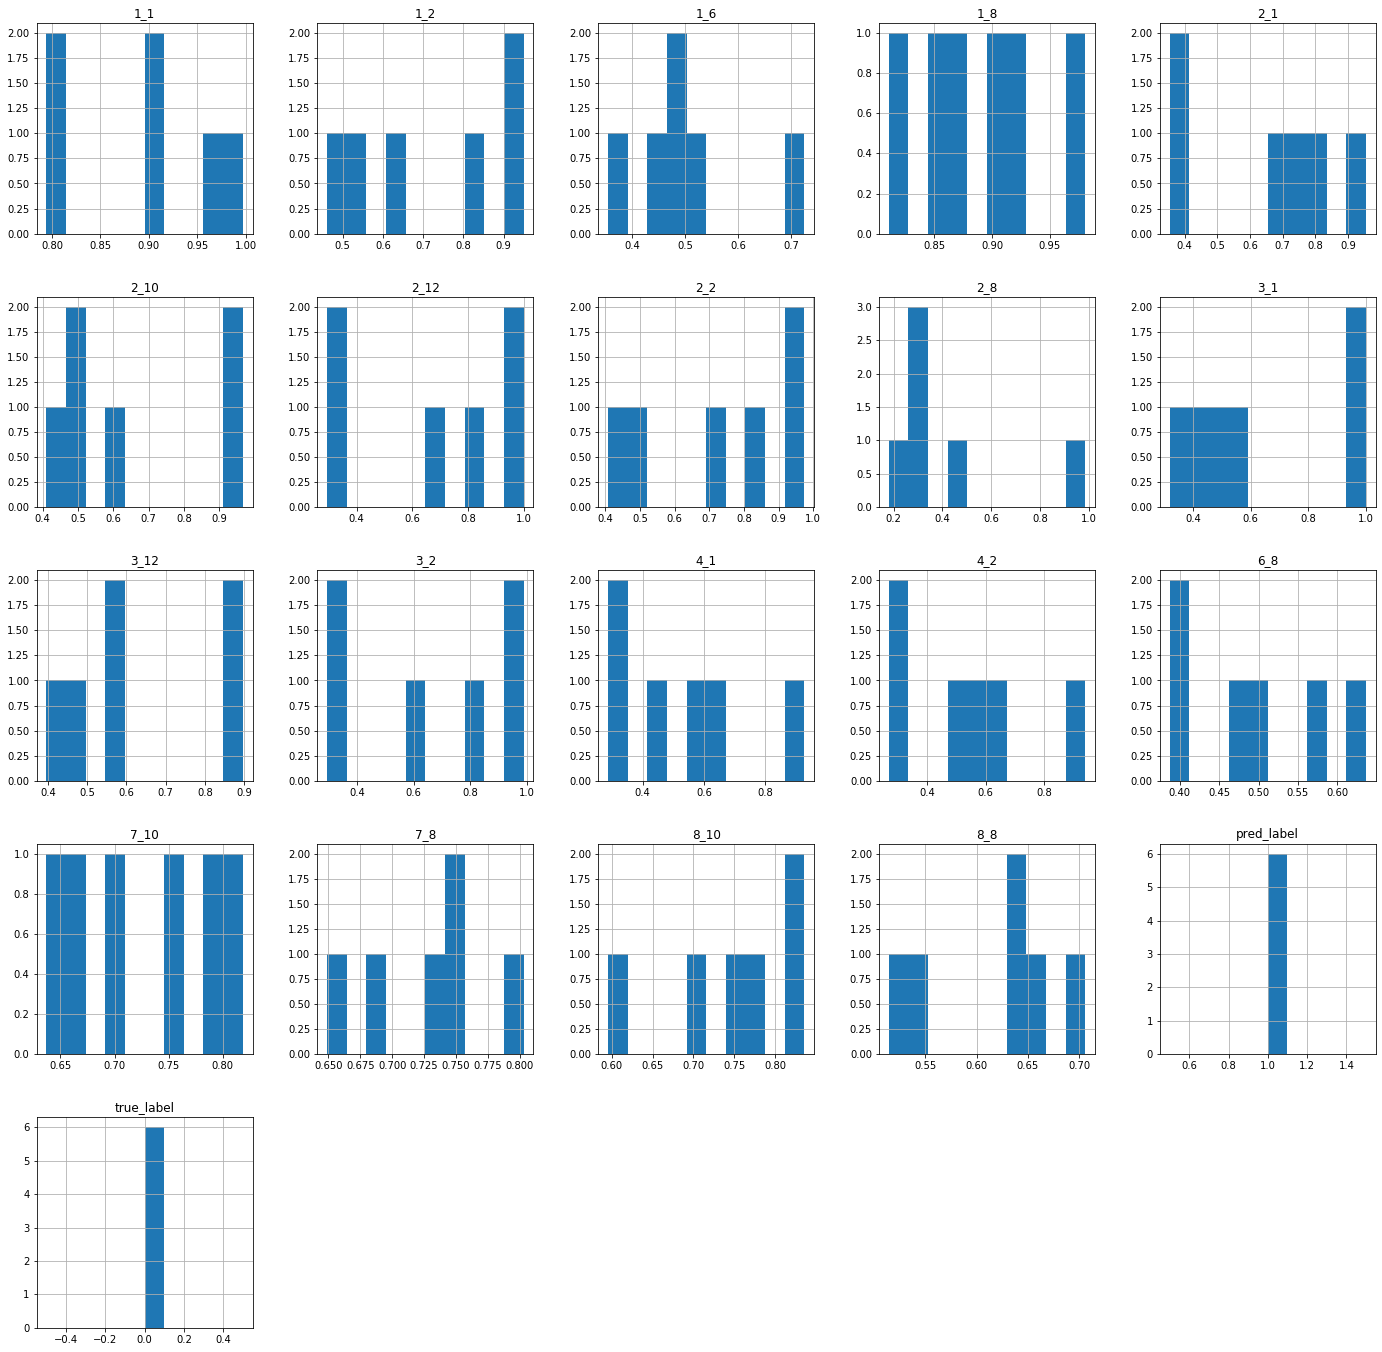

In [65]:
print_hist_models_predictions_fp(df_fp)

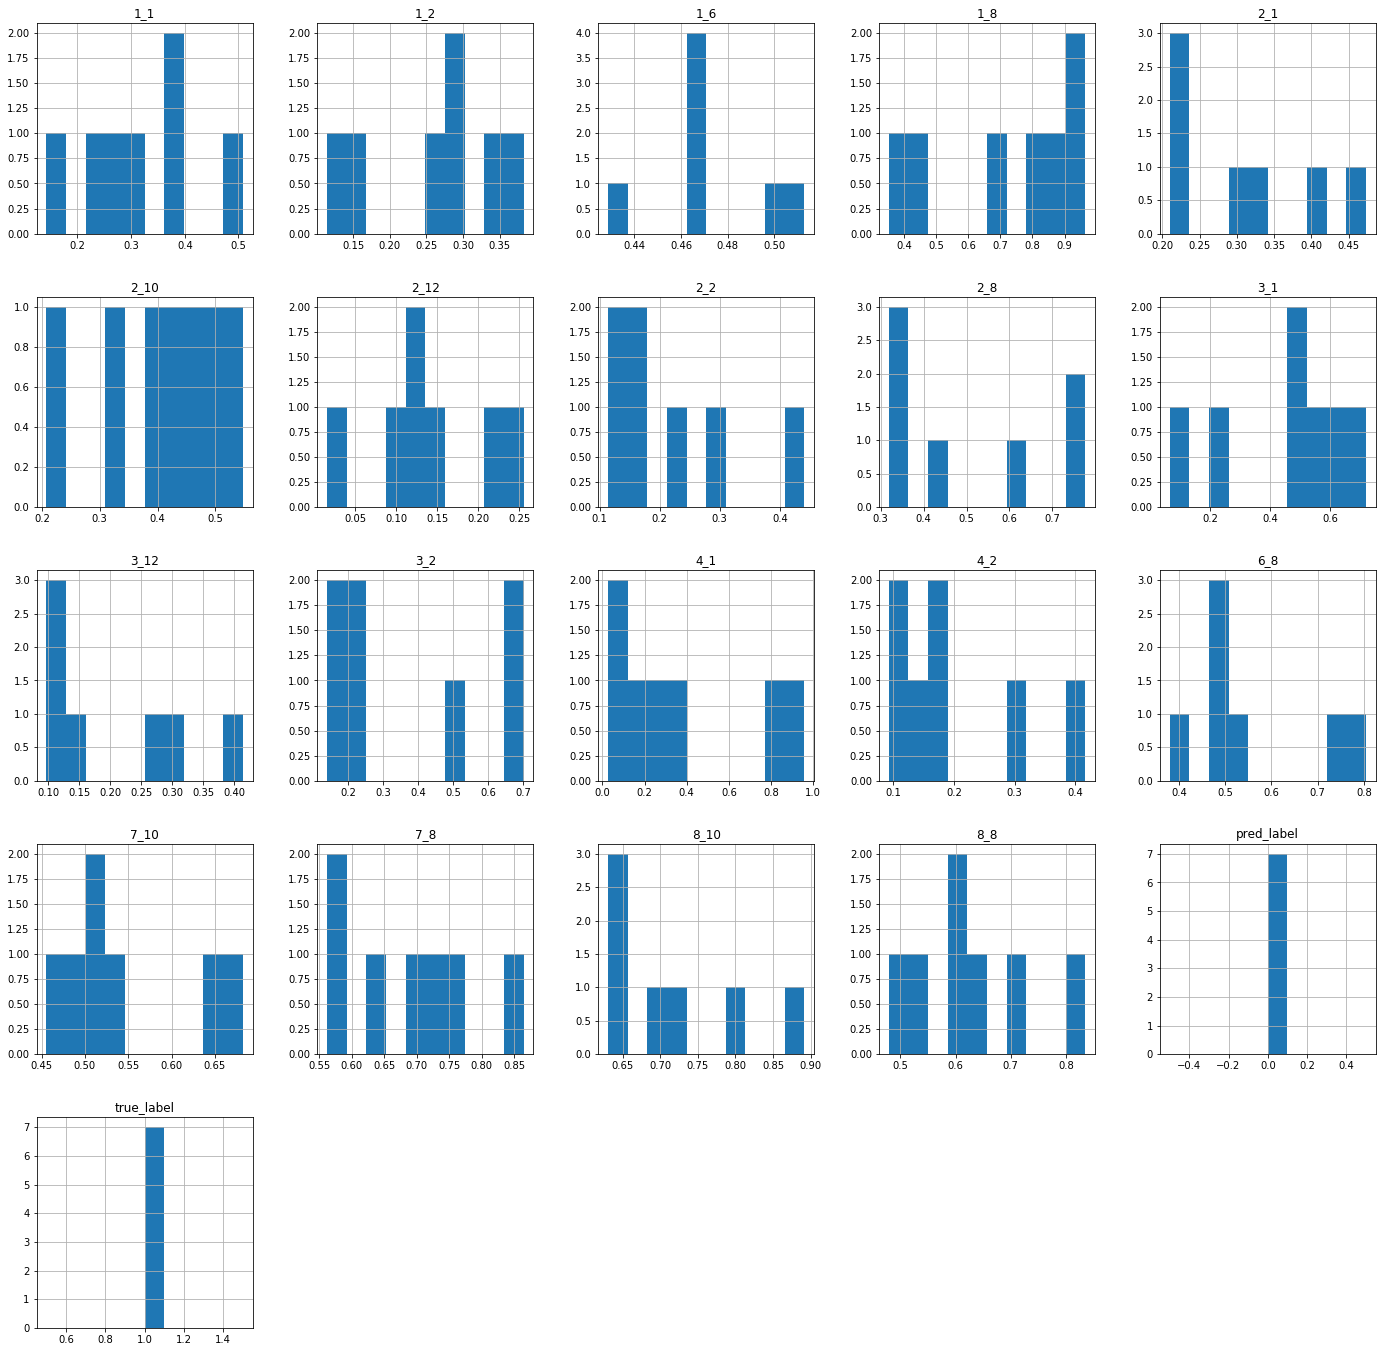

In [66]:
print_hist_models_predictions_fn(df_fn)

In [67]:
print(classification_report(df_res.true_label, df_res.pred_label))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88        56
           1       0.90      0.89      0.90        64

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120



In [68]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/avg_2_validation_ravdess_0_5.csv"
df_res.to_csv(csv_path)

# Validation - CREMA

We use the same code of the main.py of the real application, without VAD module

In [75]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}
labels= pd.Series(list(CREMA_test.emotion_label)).replace(emotion_enc)

In [76]:
predictions, model_prediction_list = make_predictions(CREMA_test, labels, prediction_scheme='avg_1')

  2%|▏         | 1/60 [00:08<08:34,  8.72s/it]

[0.04051262, 0.18811446, 0.27291948, 0.0018286705, 0.39083546, 0.5360024, 0.5805568, 0.020596355, 0.4963351, 0.6202952, 0.04574257, 0.49724323, 0.38083726, 0.03787619, 0.8229685852584051, 0.7807864445376461, 0.7762560198951558, 0.42780645303153275, 0.8298469895191192]
True label 1 Predicted label 0


  3%|▎         | 2/60 [00:17<08:20,  8.62s/it]

[0.041861624, 0.14141324, 0.32826757, 0.0025569797, 0.09667891, 0.32182604, 0.96152157, 0.003829956, 0.99505264, 0.97698903, 0.3176247, 0.95798224, 0.41079044, 0.004769385, 0.898663492225001, 0.790244503874197, 0.821935240918433, 0.398980347957092, 0.9094415151575392]
True label 1 Predicted label 0


  5%|▌         | 3/60 [00:27<08:41,  9.14s/it]

[0.93718004, 0.3363915, 0.55445606, 0.022916764, 0.18445483, 0.88584244, 0.9559157, 0.42527145, 0.98674035, 0.9164882, 0.44528472, 0.87675023, 0.39885712, 0.13263965, 0.8406116446545389, 0.9739490591380527, 0.7571927255700387, 0.40143856747662193, 0.8526659608245799]
True label 1 Predicted label 0


  7%|▋         | 4/60 [00:35<08:18,  8.89s/it]

[0.20026642, 0.33028817, 0.49645752, 0.01642552, 0.19383758, 0.68152606, 0.7286514, 0.09550616, 0.7107553, 0.7781606, 0.04026836, 0.3846348, 0.3925985, 0.04355833, 0.782781308876644, 0.8562009379090093, 0.7410359469750218, 0.5441210356378028, 0.7877769778270505]
True label 1 Predicted label 0


  8%|▊         | 5/60 [00:46<08:33,  9.33s/it]

[0.02875039, 0.13188928, 0.1722863, 0.005978912, 0.18946165, 0.43567377, 0.88857037, 0.0015755594, 0.8167528, 0.65902865, 0.036515266, 0.9042071, 0.36953825, 0.014172822, 0.8506314150063916, 0.7166375274269915, 0.7915812942694264, 0.590242785800578, 0.8545669922130269]
True label 1 Predicted label 0


 10%|█         | 6/60 [00:54<08:05,  9.00s/it]

[0.21144935, 0.36204118, 0.4518984, 0.020869493, 0.28007323, 0.2760796, 0.94773155, 0.038168997, 0.94661605, 0.7824651, 0.0154158175, 0.9720931, 0.4331817, 0.18046182, 0.8162556315358878, 0.5847944894429842, 0.7587847740086091, 0.5400748380914616, 0.8106213590674908]
True label 1 Predicted label 0


 12%|█▏        | 7/60 [01:02<07:45,  8.78s/it]

[0.9968993, 0.91370314, 0.6018269, 0.09718242, 0.3736218, 0.99464756, 0.9780351, 0.93379253, 0.9916083, 0.96535695, 0.38974428, 0.9845338, 0.34312302, 0.6513723, 0.7813505047975483, 0.9513232328269021, 0.6704043008288268, 0.2684589251876088, 0.8006024908095183]
True label 1 Predicted label 1


 13%|█▎        | 8/60 [01:11<07:31,  8.69s/it]

[0.06335071, 0.2535777, 0.37396973, 0.0024257302, 0.19853616, 0.37801346, 0.974446, 0.0005852282, 0.9903376, 0.90053105, 0.085442394, 0.9917036, 0.41894242, 0.060412854, 0.8205254017158949, 0.5378813987860791, 0.7513748547387409, 0.4126593830728123, 0.819850445282918]
True label 1 Predicted label 0


 15%|█▌        | 9/60 [01:19<07:16,  8.55s/it]

[0.0945912, 0.28177625, 0.43947107, 0.017460942, 0.28031018, 0.39079493, 0.957147, 0.022217989, 0.9817451, 0.83684343, 0.10242948, 0.947222, 0.4446115, 0.24710262, 0.851463891984186, 0.7406145423719696, 0.8126027116168928, 0.7066868505234658, 0.8553781612109188]
True label 1 Predicted label 0


 17%|█▋        | 10/60 [01:28<07:11,  8.63s/it]

[0.6279927, 0.8535013, 0.82839096, 0.12333086, 0.60218817, 0.9675396, 0.091033995, 0.7841036, 0.3060596, 0.12901238, 0.4239118, 0.31299752, 0.38743234, 0.7163693, 0.6566216325559211, 0.9397983317066554, 0.5540828781933242, 0.8074390337625688, 0.6563475080580315]
True label 0 Predicted label 0


 18%|█▊        | 11/60 [01:36<06:56,  8.49s/it]

[0.922122, 0.961813, 0.58869094, 0.007792592, 0.20592323, 0.96172535, 0.87433726, 0.97556984, 0.77264714, 0.58585477, 0.0020540059, 0.6864031, 0.366103, 0.28223675, 0.8130966405995628, 0.9773583179867618, 0.6581986450854722, 0.5108646354542592, 0.8265154387047389]
True label 1 Predicted label 0


 20%|██        | 12/60 [01:44<06:46,  8.48s/it]

[0.6289612, 0.9652308, 0.5539816, 0.032248795, 0.44111547, 0.9699482, 0.573153, 0.88656914, 0.89268243, 0.62628114, 0.33069414, 0.8057628, 0.41213173, 0.69611824, 0.7780504928054819, 0.9043587080887453, 0.680866849810758, 0.5692204612067673, 0.7804707939065106]
True label 1 Predicted label 0


 22%|██▏       | 13/60 [01:52<06:34,  8.39s/it]

[0.3830643, 0.72256494, 0.42241028, 0.013799012, 0.54178, 0.7602503, 0.6738631, 0.19732684, 0.91629714, 0.6817221, 0.08794975, 0.8309338, 0.42062473, 0.45542678, 0.7967978282986089, 0.8540754893817838, 0.6880741132789506, 0.6292538829109364, 0.8001431296634344]
True label 1 Predicted label 0


 23%|██▎       | 14/60 [02:01<06:29,  8.46s/it]

[0.20700487, 0.41011947, 0.2680862, 0.053829104, 0.47185507, 0.713677, 0.28681228, 0.0077951252, 0.77719283, 0.51814944, 0.19993597, 0.5905692, 0.4595304, 0.11541164, 0.7882298701964631, 0.8356510993499305, 0.5454549428283821, 0.601553218574, 0.7882662177652691]
True label 1 Predicted label 0


 25%|██▌       | 15/60 [02:10<06:21,  8.47s/it]

[0.017191768, 0.4264359, 0.2541024, 0.0016587973, 0.26055092, 0.8634034, 0.9952043, 0.0013565719, 0.9906, 0.9748751, 0.4234845, 0.9914793, 0.33977097, 0.10386664, 0.9000898978573564, 0.7501071590389673, 0.8366896901087437, 0.4395574027566447, 0.9069636808550925]
True label 1 Predicted label 0


 27%|██▋       | 16/60 [02:18<06:08,  8.37s/it]

[0.0010088682, 0.0043787956, 0.056212813, 9.525663e-05, 0.019112825, 0.0024932325, 0.33082107, 7.80554e-05, 0.041267186, 0.17929548, 0.00012460351, 0.26381657, 0.45551863, 0.0015028119, 0.6470020918688766, 0.7504851485391006, 0.505627055902856, 0.37007867828147145, 0.6665327401797815]
True label 0 Predicted label 0


 28%|██▊       | 17/60 [02:27<06:05,  8.50s/it]

[0.52871495, 0.24054575, 0.6527388, 0.13025281, 0.44799393, 0.53965336, 0.074478835, 0.14652115, 0.008578032, 0.15365121, 0.36751527, 0.13231933, 0.4077342, 0.88973165, 0.7362768391623477, 0.8616863951134974, 0.6619491091504472, 0.5331916559996027, 0.755628801350932]
True label 0 Predicted label 0


 30%|███       | 18/60 [02:35<05:54,  8.45s/it]

[0.3201201, 0.014890879, 0.2254619, 0.00086545944, 0.0077011883, 0.13180569, 0.9579296, 0.00031995773, 0.9523473, 0.9498981, 0.0024523437, 0.6405915, 0.37010843, 0.0019144416, 0.8646334773163453, 0.97512370375315, 0.7871600900099166, 0.5929757068853388, 0.8700619337913925]
True label 1 Predicted label 0


 32%|███▏      | 19/60 [02:44<05:51,  8.56s/it]

[0.9820195, 0.2783795, 0.72933733, 0.025556684, 0.13795742, 0.84190476, 0.99984694, 0.8029887, 0.98750377, 0.9907964, 0.11411208, 0.9997538, 0.44590747, 0.11769959, 0.7195258469987129, 0.9968820919017183, 0.7916944110400458, 0.5911145322822864, 0.7988392815906937]
True label 1 Predicted label 0


 33%|███▎      | 20/60 [02:53<05:49,  8.73s/it]

[0.83730817, 0.19693986, 0.7474335, 0.2661621, 0.052219808, 0.69521916, 0.033937395, 0.555249, 0.0404568, 0.104531705, 0.40845278, 0.018695056, 0.3247833, 0.46231705, 0.7613081364144156, 0.9625439277127618, 0.7278560343836813, 0.6905052386298535, 0.7592613355345569]
True label 0 Predicted label 0


 35%|███▌      | 21/60 [03:01<05:39,  8.71s/it]

[0.0037822127, 0.010844082, 0.23381418, 0.0046536922, 0.015349507, 0.0080604255, 0.20568445, 0.0005121231, 0.16338933, 0.1802524, 0.00027611852, 0.11228952, 0.38673124, 0.018465579, 0.6851833922337313, 0.7750524821385363, 0.5715231081171863, 0.46680461611883994, 0.6942039529792231]
True label 0 Predicted label 0


 37%|███▋      | 22/60 [03:10<05:33,  8.77s/it]

[0.99551356, 0.93804336, 0.7129123, 0.24414971, 0.38604212, 0.99711, 0.9838809, 0.9741907, 0.9250672, 0.71869385, 0.89586127, 0.90716326, 0.4078716, 0.41794905, 0.6891508364244158, 0.9974141432786482, 0.6641944716434987, 0.52692302658446, 0.7186573081394891]
True label 1 Predicted label 1


 38%|███▊      | 23/60 [03:19<05:22,  8.70s/it]

[0.985709, 0.97935045, 0.54758346, 0.05763054, 0.46281022, 0.9175264, 0.9986223, 0.9240461, 0.9970156, 0.9849963, 0.024559528, 0.99377334, 0.38183874, 0.79797554, 0.8216051573756702, 0.9764038804381555, 0.6769057228291427, 0.6171835822512675, 0.8346396636886675]
True label 1 Predicted label 1


 40%|████      | 24/60 [03:29<05:28,  9.12s/it]

[0.047337264, 0.17366052, 0.2075536, 0.021191299, 0.10357824, 0.12758264, 0.82443094, 0.014225215, 0.78914094, 0.46420956, 0.01071623, 0.48935008, 0.35723543, 0.061835915, 0.8368673616005832, 0.6476289356593941, 0.732697158115553, 0.5548638306931382, 0.8342277130093301]
True label 0 Predicted label 0


 42%|████▏     | 25/60 [03:37<05:11,  8.89s/it]

[0.14101934, 0.23381609, 0.6712887, 0.013492376, 0.26840323, 0.06949264, 0.07222867, 0.041363776, 0.52985036, 0.21631101, 0.0009497404, 0.2695012, 0.3243967, 0.2483196, 0.6912204206025492, 0.9098298448913198, 0.6515268568772733, 0.7289941553317257, 0.6940315185437903]
True label 0 Predicted label 0


 43%|████▎     | 26/60 [03:47<05:05,  9.00s/it]

[0.97668165, 0.73603195, 0.6338744, 0.0012001097, 0.12203622, 0.7950652, 0.9837665, 0.9227089, 0.96985984, 0.8994586, 0.012415707, 0.8067837, 0.33427197, 0.14020291, 0.8087933057162651, 0.9934712415798261, 0.6102856467083833, 0.6910169490969498, 0.8309088151660103]
True label 1 Predicted label 0


 45%|████▌     | 27/60 [03:55<04:53,  8.91s/it]

[0.93756056, 0.6937567, 0.56784034, 0.06345633, 0.3778921, 0.97786915, 0.99554276, 0.9088459, 0.97967327, 0.93832666, 0.43628648, 0.98925936, 0.42797855, 0.5822986, 0.8009313064014331, 0.9854650234225368, 0.6584612637094823, 0.5161962483677659, 0.8263120631599734]
True label 1 Predicted label 1


 47%|████▋     | 28/60 [04:05<04:52,  9.14s/it]

[0.17241007, 0.34433097, 0.606887, 0.014090478, 0.38633034, 0.23321626, 0.91019785, 0.020157576, 0.7814594, 0.82690847, 0.007163435, 0.64518833, 0.28295717, 0.17880118, 0.7835117524745948, 0.63521793250098, 0.7747195907268257, 0.4012038951673231, 0.7984498588266523]
True label 1 Predicted label 0


 48%|████▊     | 29/60 [04:14<04:38,  8.99s/it]

[0.024864614, 0.16428739, 0.2193397, 0.0028460324, 0.17048585, 0.2896791, 0.99920034, 0.00038173795, 0.9986024, 0.98183215, 0.049217194, 0.9879323, 0.40258563, 0.048639238, 0.9403959464159016, 0.6422257782489369, 0.9056734350931975, 0.5348052674817511, 0.9471084083303836]
True label 1 Predicted label 0


 50%|█████     | 30/60 [04:22<04:23,  8.79s/it]

[0.25992763, 0.50483775, 0.52654195, 0.021957546, 0.5088743, 0.60183406, 0.42539448, 0.046452105, 0.63767576, 0.51774377, 0.18391839, 0.3606296, 0.3499241, 0.30269992, 0.7686126721483992, 0.8044663937140896, 0.7224398541537256, 0.6447809001648872, 0.7706444046651456]
True label 1 Predicted label 0


 52%|█████▏    | 31/60 [04:31<04:13,  8.74s/it]

[0.58616066, 0.31257552, 0.2216008, 0.0021449327, 0.06455782, 0.82937133, 0.99821615, 0.11859557, 0.9945743, 0.9929284, 0.09341112, 0.97524047, 0.41521785, 0.013641566, 0.7526284844302865, 0.9783715835219916, 0.7609556829893245, 0.40920888641127245, 0.7716605831542114]
True label 1 Predicted label 0


 53%|█████▎    | 32/60 [04:39<04:03,  8.71s/it]

[0.0065906346, 0.29053783, 0.18976042, 0.0028401613, 0.18246025, 0.6503275, 0.986377, 0.0004929006, 0.9909446, 0.9631951, 0.05640629, 0.99774814, 0.2986794, 0.08839607, 0.8887373660711134, 0.6940913761571054, 0.81776311694035, 0.5465546713722798, 0.8945837015853326]
True label 1 Predicted label 0


 55%|█████▌    | 33/60 [04:48<03:52,  8.62s/it]

[0.0017913878, 0.059347242, 0.24714357, 0.004955888, 0.09281626, 0.033231497, 0.95312726, 0.0011358857, 0.7735041, 0.79041636, 0.00085797906, 0.6942818, 0.35559914, 0.072811276, 0.8180208359871711, 0.6370168474204579, 0.7617597453654272, 0.5889230877273857, 0.8170579237631267]
True label 1 Predicted label 0


 57%|█████▋    | 34/60 [04:57<03:51,  8.89s/it]

[0.03212136, 0.19936147, 0.35758013, 0.012596756, 0.13012779, 0.20284474, 0.9874581, 0.0012191832, 0.9939133, 0.9636103, 0.04399368, 0.9810095, 0.372805, 0.07269296, 0.8675137044291011, 0.7519249964683401, 0.8023866754783344, 0.5697616250752559, 0.8767375610518062]
True label 1 Predicted label 0


 58%|█████▊    | 35/60 [05:06<03:41,  8.84s/it]

[0.8238379, 0.46430045, 0.6157726, 0.016869903, 0.303274, 0.89623916, 0.47203425, 0.18690899, 0.31043047, 0.22686878, 0.03121078, 0.39284083, 0.34401262, 0.30519652, 0.7534843422254066, 0.9488374214743543, 0.6258944926562183, 0.49303341188119915, 0.7637545910057634]
True label 0 Predicted label 0


 60%|██████    | 36/60 [05:15<03:34,  8.94s/it]

[0.052438885, 0.12757128, 0.3889, 0.0069389045, 0.15387917, 0.15357438, 0.94403934, 0.008139014, 0.9960773, 0.871076, 0.050317347, 0.9685416, 0.4452328, 0.2512113, 0.7911043347649547, 0.6290445884762974, 0.6725199774088151, 0.4402308868575402, 0.8063324487769251]
True label 1 Predicted label 0


 62%|██████▏   | 37/60 [05:25<03:34,  9.31s/it]

[0.94653344, 0.8280062, 0.6667571, 0.333089, 0.8468275, 0.3772278, 0.99694633, 0.05575034, 0.9933393, 0.98708, 0.86639607, 0.99610937, 0.5036338, 0.9192238, 0.8756763983281003, 0.6486661991242244, 0.8503717748059629, 0.43438214311945894, 0.8947651821371088]
True label 1 Predicted label 1


 63%|██████▎   | 38/60 [05:34<03:18,  9.02s/it]

[0.10593364, 0.10564941, 0.41466245, 0.09967819, 0.12317261, 0.21897238, 0.9154985, 0.006624192, 0.9198701, 0.6924646, 0.10579008, 0.8921697, 0.39428338, 0.047455788, 0.8169906486321242, 0.7118028533717068, 0.8239183267388569, 0.6631033332688222, 0.8086070021787126]
True label 1 Predicted label 0


 65%|██████▌   | 39/60 [05:42<03:06,  8.87s/it]

[0.00062701106, 0.04126486, 0.17148158, 0.00012211426, 0.20835483, 0.007501453, 0.9961339, 0.0004017651, 0.9949366, 0.9957662, 5.9406055e-05, 0.98376465, 0.32383996, 0.051817268, 0.9181844569432824, 0.6532156684550803, 0.8746346624969026, 0.4443574165468045, 0.9283917834911479]
True label 1 Predicted label 0


 67%|██████▋   | 40/60 [05:51<02:55,  8.79s/it]

[0.99085355, 0.9612436, 0.9732386, 0.28479677, 0.67650187, 0.8758513, 0.9965043, 0.8239782, 0.9933387, 0.96124625, 0.95364594, 0.9904231, 0.42727104, 0.843217, 0.7788191225938135, 0.9961886137004224, 0.7981243278891529, 0.8810034682443718, 0.8340134189931203]
True label 1 Predicted label 1


 68%|██████▊   | 41/60 [06:00<02:49,  8.93s/it]

[0.06772196, 0.38228142, 0.55873686, 0.0027453005, 0.26530787, 0.046011955, 0.8760549, 0.06668219, 0.95280457, 0.8019822, 0.0028220713, 0.75388765, 0.38605124, 0.6031228, 0.7491273169449948, 0.8269226970747682, 0.6027219611062345, 0.5206312342524081, 0.7663687758373677]
True label 1 Predicted label 0


 70%|███████   | 42/60 [06:08<02:36,  8.72s/it]

[0.018267483, 0.027986765, 0.24271402, 0.0009967983, 0.21431217, 0.022624612, 0.9957497, 0.000109398025, 0.99059784, 0.98874915, 0.00840956, 0.9769709, 0.2979108, 0.08336106, 0.8917005732551461, 0.6446813690812931, 0.7526807011964027, 0.4139893894517625, 0.9014370040246005]
True label 1 Predicted label 0


 72%|███████▏  | 43/60 [06:17<02:28,  8.74s/it]

[0.9981593, 0.099297434, 0.68034756, 0.3624552, 0.33888823, 0.78883415, 0.8793161, 0.55080926, 0.9973115, 0.6984153, 0.48704618, 0.9723551, 0.39139307, 0.6947846, 0.7476360377838154, 0.9810595232904086, 0.7549495026432348, 0.7088339711617899, 0.766608187556932]
True label 1 Predicted label 0


 73%|███████▎  | 44/60 [06:26<02:18,  8.69s/it]

[0.60919887, 0.09219238, 0.49512008, 0.13918445, 0.109188914, 0.57240516, 0.7248041, 0.07357031, 0.8830178, 0.63303626, 0.12991247, 0.6850628, 0.38322505, 0.05321327, 0.7788797562868933, 0.9679129121258279, 0.721976146092752, 0.5645536135334264, 0.7960830221336989]
True label 1 Predicted label 0


 75%|███████▌  | 45/60 [06:34<02:07,  8.52s/it]

[0.3189873, 0.2209642, 0.45549223, 0.04136148, 0.22711295, 0.41356337, 0.9304472, 0.0011840463, 0.97731185, 0.8620597, 0.5355888, 0.87808925, 0.30641186, 0.06395167, 0.7029637317469551, 0.5958258256845782, 0.5304247115023699, 0.18900733174736886, 0.7047930727571367]
True label 1 Predicted label 0


 77%|███████▋  | 46/60 [06:42<01:59,  8.54s/it]

[0.0025042892, 0.032871783, 0.25306386, 0.0036396086, 0.07496163, 0.033248812, 0.9503161, 0.00017637014, 0.93892395, 0.94462204, 0.03061518, 0.74346757, 0.2466596, 0.06958583, 0.8103877037161619, 0.7899095095622336, 0.7909864512934238, 0.5954072541318668, 0.8274521192843252]
True label 1 Predicted label 0


 78%|███████▊  | 47/60 [06:51<01:50,  8.53s/it]

[0.03076312, 0.28326812, 0.33859605, 0.0016233325, 0.17365125, 0.31130162, 0.9212335, 0.01964575, 0.90414476, 0.8300572, 0.0005709827, 0.6634397, 0.37055492, 0.03894952, 0.8041845474260543, 0.8502878970877696, 0.7112109874360799, 0.5431551714310806, 0.8113279087304935]
True label 1 Predicted label 0


 80%|████████  | 48/60 [07:00<01:44,  8.68s/it]

[0.047711045, 0.7708006, 0.32513553, 0.0032716393, 0.37146342, 0.7767086, 0.1428512, 0.008045554, 0.10453123, 0.16000155, 0.0064603686, 0.056283414, 0.38062373, 0.19163373, 0.8314688806790026, 0.7870358371132573, 0.70935344046074, 0.5174397462773074, 0.8336595391480588]
True label 0 Predicted label 0


 82%|████████▏ | 49/60 [07:09<01:35,  8.72s/it]

[0.43452662, 0.9239981, 0.6662792, 0.032114327, 0.43242192, 0.5641894, 0.10648325, 0.80996776, 0.1248669, 0.18614984, 0.14426714, 0.25863796, 0.41868895, 0.73922664, 0.7799265249727543, 0.9460916531021439, 0.6308606830141381, 0.7191446689975717, 0.7888687157337161]
True label 0 Predicted label 0


 83%|████████▎ | 50/60 [07:17<01:26,  8.65s/it]

[0.020013154, 0.21425903, 0.37862927, 0.011613816, 0.2535508, 0.095727, 0.9913933, 0.0148668885, 0.9897958, 0.97699106, 0.051229537, 0.94526386, 0.34263346, 0.19662455, 0.8849786159884035, 0.4939962899422734, 0.7997293059318141, 0.4086634574487343, 0.884128111452401]
True label 1 Predicted label 0


 85%|████████▌ | 51/60 [07:27<01:20,  8.92s/it]

[0.34984392, 0.36954534, 0.80261326, 0.0055125356, 0.56316024, 0.26343513, 0.9705941, 0.19963965, 0.9900804, 0.91711926, 0.22821876, 0.9944005, 0.28449497, 0.25105166, 0.5951768914801829, 0.9952029350543854, 0.7937803305378958, 0.7974450064878779, 0.6434512341226063]
True label 1 Predicted label 0


 87%|████████▋ | 52/60 [07:35<01:09,  8.68s/it]

[0.9960569, 0.5418371, 0.28258115, 0.013397515, 0.0953725, 0.9981064, 0.9894122, 0.6111374, 0.6425872, 0.816384, 0.28266186, 0.91531813, 0.2976968, 0.029177785, 0.7031707472844364, 0.9942349748062995, 0.787829070537809, 0.4446101470724274, 0.8286900341475193]
True label 1 Predicted label 0


 88%|████████▊ | 53/60 [07:44<01:00,  8.70s/it]

[0.010442704, 0.06812486, 0.19258392, 0.0029405355, 0.0822289, 0.17807224, 0.9287493, 0.00058948994, 0.90254843, 0.8090221, 0.041178167, 0.41732296, 0.33608127, 0.02364406, 0.8301088839930972, 0.6842410702118416, 0.7573597742370696, 0.5432886386045714, 0.8348931142802011]
True label 1 Predicted label 0


 90%|█████████ | 54/60 [07:52<00:51,  8.64s/it]

[0.8082742, 0.8655453, 0.5253555, 0.0032652617, 0.5602844, 0.9909297, 0.7716357, 0.60695004, 0.97347534, 0.7490036, 0.08288297, 0.5927805, 0.38088498, 0.6040165, 0.8408415679978068, 0.8885232403887321, 0.7657458986525544, 0.41336647441323976, 0.8466629556355005]
True label 1 Predicted label 0


 92%|█████████▏| 55/60 [08:00<00:42,  8.49s/it]

[0.9994865, 0.19025317, 0.6928935, 0.0017024279, 0.36260968, 0.4720466, 0.9988706, 0.35063076, 0.9992187, 0.9863937, 0.19613257, 0.9974656, 0.37577966, 0.20368347, 0.853057803519019, 0.9930900132070772, 0.82189918184638, 0.512207972765496, 0.885986458385617]
True label 1 Predicted label 0


 93%|█████████▎| 56/60 [08:08<00:33,  8.43s/it]

[0.24980363, 0.11355761, 0.47102684, 0.0447942, 0.5478647, 0.40042287, 0.045991987, 0.12382561, 0.2067655, 0.03723657, 0.13567847, 0.1472638, 0.44149348, 0.41056383, 0.7101576089655234, 0.8740002201885759, 0.6254314537056515, 0.7670190231383599, 0.7061107296687276]
True label 0 Predicted label 0


 95%|█████████▌| 57/60 [08:17<00:25,  8.34s/it]

[0.6929891, 0.4527575, 0.5872742, 0.016749233, 0.29025048, 0.45630398, 0.05690798, 0.20866883, 0.039856076, 0.27296326, 0.011248022, 0.25984812, 0.4319073, 0.4716563, 0.6603034929629508, 0.926558700893501, 0.482975570543389, 0.5405863573680855, 0.6569630321929905]
True label 0 Predicted label 0


 97%|█████████▋| 58/60 [08:25<00:16,  8.40s/it]

[0.167965, 0.16404623, 0.7258187, 0.00881356, 0.13866389, 0.6498859, 0.97628075, 0.3327787, 0.9433589, 0.7402018, 0.2644285, 0.7583767, 0.3715734, 0.29705724, 0.7383720173735095, 0.9653309115762203, 0.42220496577265026, 0.3299533328336263, 0.7659171863855843]
True label 1 Predicted label 0


 98%|█████████▊| 59/60 [08:33<00:08,  8.29s/it]

[0.96919465, 0.5013953, 0.95213413, 0.2429367, 0.5406688, 0.967735, 0.8848463, 0.91639686, 0.9719175, 0.86430174, 0.92260325, 0.98230493, 0.47407493, 0.6965438, 0.7639907993296181, 0.9941660017002383, 0.7313905360841548, 0.6704910933044456, 0.8117087909908218]
True label 1 Predicted label 1


100%|██████████| 60/60 [08:41<00:00,  8.70s/it]

[0.4334576, 0.12727395, 0.445144, 0.0011827052, 0.042812973, 0.2250163, 0.99956167, 0.024490833, 0.9684287, 0.985146, 0.02503103, 0.99080825, 0.37109601, 0.007591516, 0.7653043959846231, 0.9849268094069183, 0.8203910068978497, 0.3705546755968322, 0.8195866291140462]
True label 1 Predicted label 0


In [77]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels, df_predictions, df_model_predictions, CREMA_test)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

In [78]:
print_hist_models_predictions_fp(df_fp)

DataFrame False Positives is empty!


0

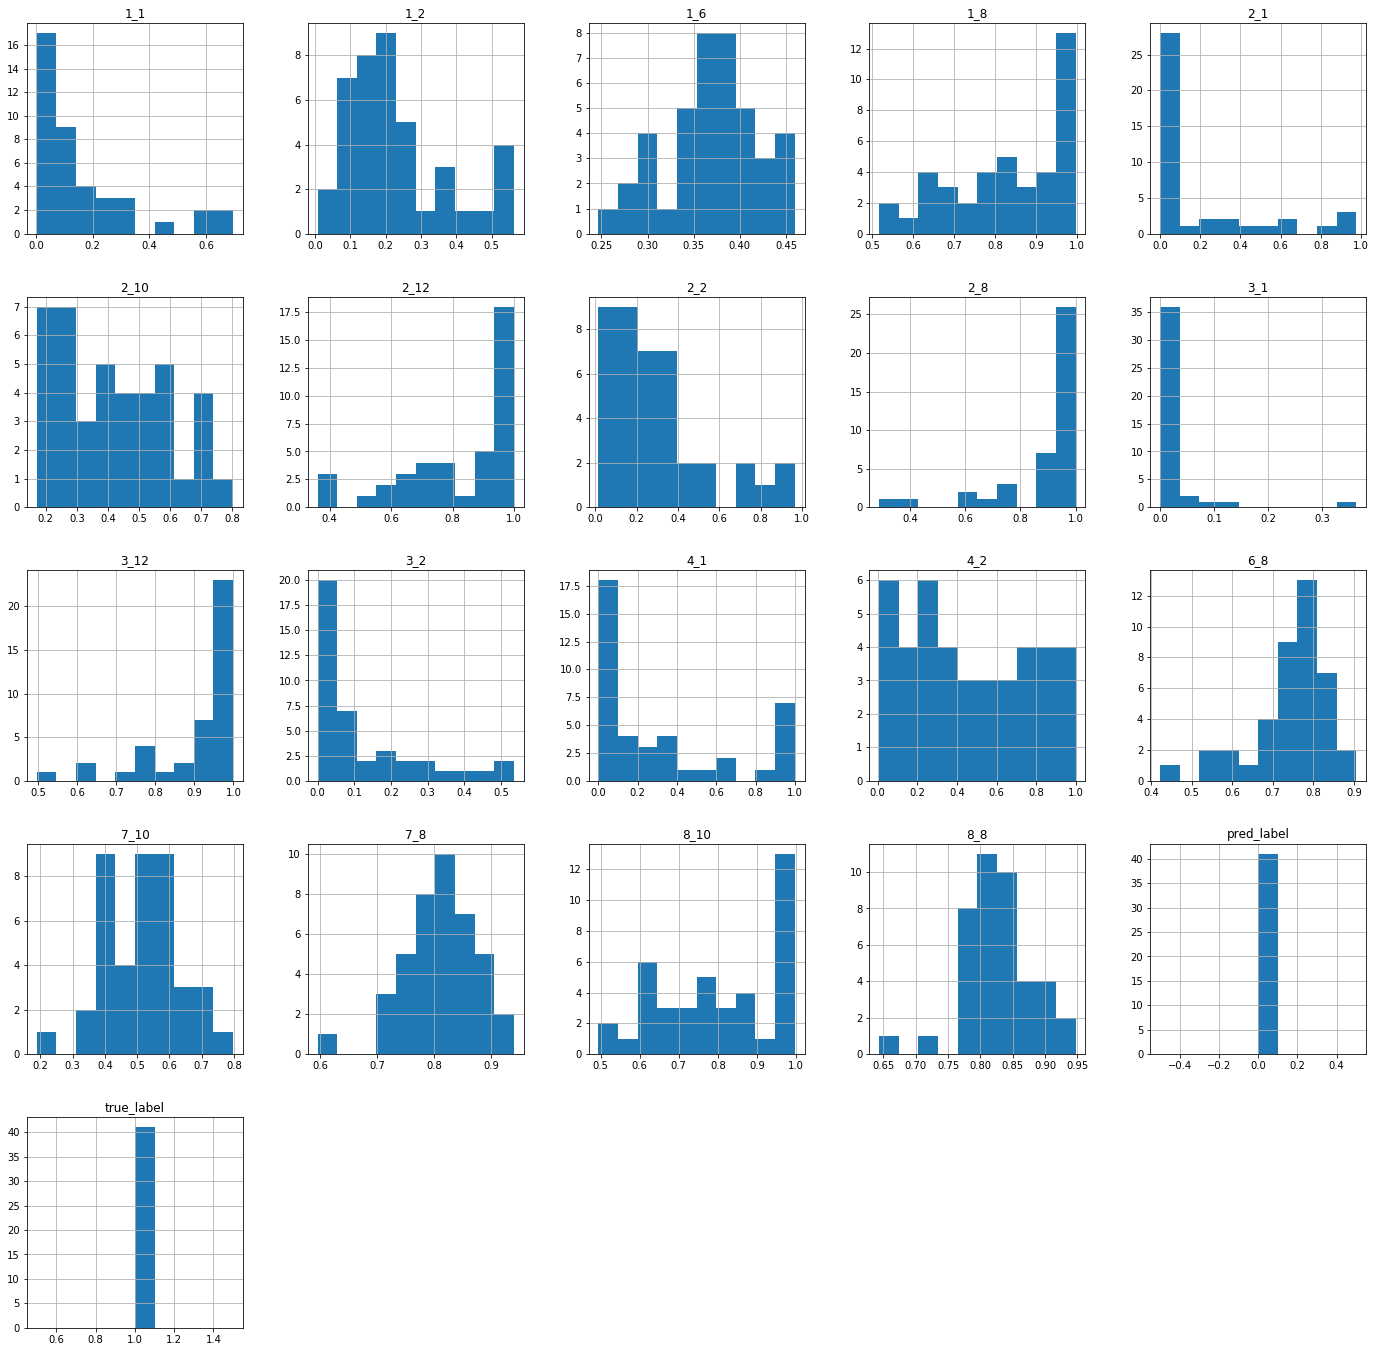

In [79]:
print_hist_models_predictions_fn(df_fn)

In [80]:
print(classification_report(df_res.true_label, df_res.pred_label))

              precision    recall  f1-score   support

           0       0.23      1.00      0.37        12
           1       1.00      0.15      0.25        48

    accuracy                           0.32        60
   macro avg       0.61      0.57      0.31        60
weighted avg       0.85      0.32      0.28        60



In [81]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/avg_2_validation_crema_0_5.csv"
df_res.to_csv(csv_path)